In [ ]:
import numpy as np; import pandas as pd; import sklearn as sk; import matplotlib.pyplot as plt; import seaborn as sns; import os
import random; from scipy import stats; from sklearn import preprocessing; from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy.lib.recfunctions as rfn; import statsmodels.api as sm; from statsmodels.graphics.regressionplots import abline_plot
import numpy as np; from sklearn.linear_model import LinearRegression; from sklearn.metrics import mean_squared_error, r2_score
import math; from sklearn import linear_model
from numpy import linalg; from scipy import stats; import cv2; import math; from matplotlib import cm; from matplotlib import colors
import matplotlib as mpl; from matplotlib.ticker import (AutoMinorLocator, MultipleLocator); import scipy.stats as st; import scipy as sp
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import os; print(os.getcwd())
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib import cm
import matplotlib.patches as mpatches
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/content
Mounted at /content/gdrive


#Data Import

In [ ]:
json_files = ["/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_World_Cup.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_European_Championship.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_England.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_France.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_Germany.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_Italy.json",
              "/content/gdrive/MyDrive/COMP6200project/Soccer/Data/events/events_Spain.json"]

json_codes = ["WC","EU","EN","FR","DE","IT","ES"]


################################################################################################
# Load and basic trimming
################################################################################################
for i in range(len(json_files[:])):
  #i=0
  print(i)    
  dfraw = pd.read_json(json_files[i])
  dfred = dfraw[["teamId","matchId","eventSec","matchPeriod","positions","eventName","subEventName","tags"]]
  dfred.insert(0,"comp",json_codes[i])
  if i == 0: df = pd.DataFrame.copy(dfred)
  if i != 0: df = pd.concat([df,dfred])

df = df.reset_index(drop=True)

dforig = df.copy()

# identify goals and own-goals from the tags metadata
#####
df["goal"] = ""

idx = df["tags"].astype(str).str.contains("\{'id': 101\}")
df.loc[idx,"goal"] = "goal"

idx = df["tags"].astype(str).str.contains("\{'id': 102\}")
df.loc[idx,"goal"] = "own-goal"

# identify offensive dribbles from the tags metadata
#####
df["off_dribble"] = False

idx0 = df["subEventName"] == "Ground attacking duel"
idx1 = df["tags"].astype(str).str.contains("\{'id': 501\}")
idx2 = df["tags"].astype(str).str.contains("\{'id': 502\}")
idx3 = df["tags"].astype(str).str.contains("\{'id': 503\}")
idx4 = df["tags"].astype(str).str.contains("\{'id': 504\}")
idx5 = np.logical_or.reduce((idx1, idx2, idx3, idx4))
idx6 = np.logical_and(idx0,idx5)
df.loc[idx6,"off_dribble"] = True

# identify successful touches
#####
df["good_tch"] = False

idx0 = df["subEventName"] == "Touch"
idx1 = df["tags"].astype(str).str.contains("\[\]")
idx2 = np.logical_and(idx0,idx1)
df.loc[idx2,"good_tch"] = True


df = df.drop("tags",axis=1)

# process co-ordinate data
#####
df["positions"] = df["positions"].astype(str).str.replace(r"\[\{'y': ","")
df["positions"] = df["positions"].astype(str).str.replace(r" 'x': ","")
df["positions"] = df["positions"].astype(str).str.replace(r"\}, \{'y': ",",")
df["positions"] = df["positions"].astype(str).str.replace(r"\}\]","")
dfpos = df["positions"].str.split(',', expand=True)
dfpos.columns = ["x0","y0","x1","y1"]

df = pd.concat([df, dfpos], axis=1)
df = df.drop("positions",axis=1)

################################################################################################
# Start second half time at 60 minutes
################################################################################################
#np.unique(df['matchPeriod'])
# np.max(df.loc[df['matchPeriod']=="1H","eventSec"])   # 3302s = 55m
# np.max(df.loc[df['matchPeriod']=="2H","eventSec"])   # 3537s = 59m
# np.max(df.loc[df['matchPeriod']=="E1","eventSec"])   # 1117s = 18m
# np.max(df.loc[df['matchPeriod']=="E2","eventSec"])   # 1163s = 18m
# np.max(df.loc[df['matchPeriod']=="P","eventSec"])    # 680s  = 12m

df.loc[df['matchPeriod']=="2H","eventSec"] = df.loc[df['matchPeriod']=="2H","eventSec"] + 60*60    #start second half time at 60 minutes
df.loc[df['matchPeriod']=="E1","eventSec"] = df.loc[df['matchPeriod']=="E1","eventSec"] + 120*60   #start ET1 at 120 minutes
df.loc[df['matchPeriod']=="E2","eventSec"] = df.loc[df['matchPeriod']=="E2","eventSec"] + 150*60   #start ET2 at 150 minutes
df.loc[df['matchPeriod']=="P","eventSec"]  = df.loc[df['matchPeriod']=="P","eventSec"] + 180*60   #start Pens at 180 minutes
df = df.drop("matchPeriod",axis=1)

################################################################################################
# Make goal and own-goal events
################################################################################################
idx = np.where(df["goal"] == "goal")[0]

for i in range(len(idx)):
    temprow = pd.DataFrame.copy(df.iloc[idx[i],:])
    temprow["subEventName"] = "goal"
    temprow = pd.DataFrame(temprow).T

    if i == 0: rowstoadd = temprow
    if i != 0: rowstoadd = pd.concat([rowstoadd,temprow])


idx = np.where(df["goal"] == "own-goal")[0]

for i in range(len(idx)):
    temprow = pd.DataFrame.copy(df.iloc[idx[i],:])
    temprow["subEventName"] = "own-goal"
    temprow = pd.DataFrame(temprow).T

    rowstoadd = pd.concat([rowstoadd,temprow])

df = pd.concat([df,rowstoadd])

################################################################################################
# Sort df (so things are back in event order after the goal concatenation above)
################################################################################################

df = df.sort_values(by=["comp","matchId","eventSec"])

################################################################################################
################################################################################################
#### Filter out unwanted actions and map WyScout actions according to my simple actions scheme
################################################################################################
################################################################################################
df["actcomb"] = df["eventName"] + "_" + df["subEventName"]

#np.unique(df["act"])

simple_actions = ['Foul_Foul','Foul_Hand foul','Foul_Late card foul','Foul_Out of game foul','Foul_Protest','Foul_Simulation','Foul_Time lost foul',
                  'Foul_Violent Foul','Offside_','Free Kick_Corner','Free Kick_Free Kick','Free Kick_Free kick cross','Free Kick_Free kick shot',
                  'Free Kick_Goal kick','Free Kick_Penalty','Free Kick_Throw in','Pass_Cross','Pass_Hand pass','Pass_Head pass','Pass_High pass',
                  'Pass_Launch','Pass_Simple pass','Pass_Smart pass','Shot_Shot',
                  'Shot_goal','Free Kick_goal','Others on the ball_own-goal','Pass_own-goal',
                  'Duel_Ground attacking duel',
                  'Others on the ball_Acceleration','Others on the ball_Clearance','Others on the ball_Touch']
idx = np.isin(df["actcomb"],simple_actions)
df = df.loc[idx,:]

df["act"] = ""
##### x
idx = np.isin(df["actcomb"],['Foul_Foul','Foul_Hand foul','Foul_Late card foul','Foul_Out of game foul',
                         'Foul_Protest','Foul_Simulation','Foul_Time lost foul','Foul_Violent Foul','Offside_'])
df.loc[idx,"act"] = "x"

##### 0
idx = df["actcomb"]=='Free Kick_Goal kick'
df.loc[idx,"act"] = "0"

##### 1
idx = df["actcomb"]=='Free Kick_Throw in'
df.loc[idx,"act"] = "1"

##### 2
idx = df["actcomb"]=='Free Kick_Corner'
df.loc[idx,"act"] = "2"

##### 3
idx = df["actcomb"]=='Free Kick_Free Kick'
df.loc[idx,"act"] = "3"

##### 4
idx = df["actcomb"]=='Free Kick_Free kick cross'
df.loc[idx,"act"] = "4"

##### 5
idx = df["actcomb"]=='Free Kick_Free kick shot'
df.loc[idx,"act"] = "5"

##### 6
idx = df["actcomb"]=='Free Kick_Penalty'
df.loc[idx,"act"] = "6"

##### c
idx = df["actcomb"]=='Pass_Cross'
df.loc[idx,"act"] = "c"

##### p
idx = np.isin(df["actcomb"],['Pass_Hand pass','Pass_Head pass','Pass_High pass','Pass_Launch','Pass_Simple pass','Pass_Smart pass'])
df.loc[idx,"act"] = "p"

##### s
idx = df["actcomb"]=='Shot_Shot'
df.loc[idx,"act"] = "s"

##### g
idx = np.isin(df["actcomb"],['Shot_goal','Free Kick_goal'])
df.loc[idx,"act"] = "g"

##### h
idx = np.isin(df["actcomb"],['Others on the ball_own-goal','Pass_own-goal'])
df.loc[idx,"act"] = "h"

##### d
idx = df['off_dribble'] == True
df.loc[idx,"act"] = "d"

##### t
idx = np.isin(df["actcomb"],['Others on the ball_Acceleration'])
df.loc[idx,"act"] = "t"

idx = df['good_tch'] == True
df.loc[idx,"act"] = "t"

##### o
idx = np.isin(df["actcomb"],['Others on the ball_Clearance'])
df.loc[idx,"act"] = "o"

#np.unique(df["act"],return_counts=True)

################################################################################################
# determine possession (and filter out actions not by the team in possession)
################################################################################################
df1a = df.copy()

df["pos"] = 0
df = df.reset_index(drop=True)

for i in range(df.shape[0]):
  if i == 0:
    df["pos"][0] = df["teamId"][0]
  else:
    prevpos = df["pos"][i-1]
    curact  = df["act"][i]
    curteam = df["teamId"][i]
    if prevpos == curteam:       #if the team that previously was classified as being in possession now has possession then let's classify that possession as continuing
      df["pos"][i] = curteam
    else:
      if np.isin(curact,['0','1','2','3','4','5','6','c','p','s','g','t','d','o']):
        df["pos"][i] = curteam
      else:
        df["pos"][i] = prevpos
#most possession ends up just being the same as the team who is performing the action (in our truncated list of actions)
#but there are occassions where possession is retained despite an action from the other team - in particular when the other team fouls

#filter out actions not by the team in possession
df = df.loc[df["teamId"] == df["pos"],:]
df = df.reset_index(drop=True)
#remove events that aren't part of the scheme
idx = df['act'] != ""
df = df.loc[idx,:]
df = df.reset_index(drop=True)

df2 = df.copy()

################################################################################################
# tidying up to improve performance
################################################################################################

df = df.drop(["eventName","subEventName"],axis=1)
df["eventSec"] = df["eventSec"].astype(int)
df = df.loc[:,["comp","matchId","teamId","eventSec","pos","act","x0","y0","x1","y1"]]
# df.columns = ["cmp","MID","TID","T","pos","act","x0","y0","x1","y1"]

################################################################################################
# determine score difference
################################################################################################
df3 = df.copy()
#df = df3.copy()

##########
#make a matchlog - which team played which during each match
df["matchteam"] = df["matchId"].astype(str) + "_" + df["teamId"].astype(str)
matchteams = np.unique(df["matchteam"])
matchteams = np.array(matchteams,dtype=str)

matchlog = pd.DataFrame(matchteams,columns=["matchteam"])
matchlog.insert(1,"team_vs",0)

for i in range(len(matchlog)):
  #i = 0
  temp0 = matchlog.loc[i,"matchteam"]
  temp0match = np.str.split(temp0,"_")[0]
  temp1matchteams = matchteams[np.flatnonzero(np.core.defchararray.find(matchteams,temp0match+"_")!=-1)]
  matchlog.loc[i,"team_vs"] = str(temp1matchteams[temp1matchteams != temp0][0])
  if i % 100 == 0: print(i)

matchlog['team_vs2'] = matchlog['team_vs'].str.split('_').str[1]

##########
#assign team played against
df = pd.merge(df,matchlog.loc[:,["matchteam","team_vs2"]],left_on="matchteam",right_on="matchteam",how="left")
df = df.rename({'team_vs2':'team_vs'},axis=1)

df.team_vs = pd.to_numeric(df.team_vs)

##########
#assign score advantage
df["scrad"] = 0
matches = np.unique(df["matchId"])
for j in range(len(matches)):
  #j=0
  m = matches[j]
  print(m,j)

  matchidx = df["matchId"] == m
  matchidxn = np.where(matchidx)[0]
  match_start_idxn = min(matchidxn)
  match_end_idxn   = max(matchidxn)

  #assign scrad for goals
  goals_idxn = np.where(np.logical_and(df["act"]=="g",df["matchId"] == m))[0]
  num_goals = len(goals_idxn)
  for i in range(num_goals):
    goal_idxn = goals_idxn[i]
    goal_scored_by = df.loc[goal_idxn]["teamId"]
    df.loc[np.logical_and(np.in1d(np.arange(len(df)), np.arange(goal_idxn,match_end_idxn+1)),
                          df["teamId"]==goal_scored_by),
          "scrad"] += 1
    df.loc[np.logical_and(np.in1d(np.arange(len(df)), np.arange(goal_idxn,match_end_idxn+1)),
                        df["team_vs"]==goal_scored_by),
          "scrad"] -= 1

  #assign scrad for own-goals
  goals_idxn = np.where(np.logical_and(df["act"]=="h",df["matchId"] == m))[0]   #same code as above, just now act type "h" (own-goal), as opposed to "g" (goal)
  num_goals = len(goals_idxn)
  for i in range(num_goals):
    print(i)
    goal_idxn = goals_idxn[i]
    goal_scored_by = df.loc[goal_idxn]["team_vs"]                               #team_vs get the goal, when it is an own-goal
    df.loc[np.logical_and(np.in1d(np.arange(len(df)), np.arange(goal_idxn,match_end_idxn+1)),
                          df["teamId"]==goal_scored_by),
          "scrad"] += 1
    df.loc[np.logical_and(np.in1d(np.arange(len(df)), np.arange(goal_idxn,match_end_idxn+1)),
                        df["team_vs"]==goal_scored_by),
          "scrad"] -= 1
  
  if j % 100 == 0: print(j)

#df.to_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/df_all_20210719am1.csv")

#plt.hist(df["scrad"])

################################################################################################
# distance and bearing
################################################################################################
## need to add something in to calculate distance and bearing!!

df.x0 = pd.to_numeric(df.x0)
df.y0 = pd.to_numeric(df.y0)
df.x1 = pd.to_numeric(df.x1)
df.y1 = pd.to_numeric(df.y1)

x00 = df[1:]["x0"].to_numpy()*1.05     #to scale for the actual dimensions of a soccer pitch...
x01 = df[:-1]["x0"].to_numpy()*1.05
y00 = df[1:]["y0"].to_numpy()*0.68
y01 = df[:-1]["y0"].to_numpy()*0.68

s = ((x00-x01)**2+(y00-y01)**2)**0.5
s = np.append(s,0)
df["dist"] = s

theta = np.arctan2(y00-y01,x00-x01)/np.pi*180
theta = np.append(theta,0)
df["theta"] = theta


matches = np.unique(df["matchId"])
j=1
for j in range(len(matches)):
  m = matches[j]
  matchidx = df["matchId"] == m
  matchidxn = np.where(matchidx)[0]
  #match_start_idxn = min(matchidxn)
  match_end_idxn   = max(matchidxn)
  df.loc[match_end_idxn,"dist"]=0
  df.loc[match_end_idxn,"theta"]=0

  if j % 100 == 0: print(j)

################################################################################################
# time difference
################################################################################################

t00 = df[1:]["eventSec"].to_numpy()
t01 = df[:-1]["eventSec"].to_numpy()

t = t00-t01
t = np.append(0,t)
#'np.sum(t > 60)/np.shape(t)[0]
t[t>60] = 60
t[t<0] = 0

df["deltaT"] = t


################################################################################################
# add phase tags
################################################################################################

p00 = df[1:]["pos"].to_numpy()
p01 = df[:-1]["pos"].to_numpy()

new_possession_idxn = np.where(p00 != p01)[0]+1   #407226 unique possessions

df["posID"] = 0

posID = np.zeros(df.shape[0])
i=0
for p in new_possession_idxn:
  posID[p:]+=1
  i += 1
  if i % 1000 == 0: print(i)

df["posID"] = posID
df["posID"] = df["posID"].astype(int)


##########################################################################################
# PRE-PROCESS THE DATA
##########################################################################################

#dforig = pd.read_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/df_all_20210719am4.csv")
#df = dforig.drop("Unnamed: 0",axis=1)

#trim, re-arrange
df = df.drop(["teamId","x1","y1","matchteam","team_vs"],axis=1)
df = df.loc[:,["comp","matchId","pos","posID","act","eventSec","deltaT","x0","y0","dist","theta","scrad"]]
df.columns = ["comp","MID","TID","PID","act","T","deltaT","x0","y0","s","theta","scrad"]

#scale
df["T"] = df["T"]/max(df["T"])
df["deltaT"] = df["deltaT"]/max(df["deltaT"])
df["x0"] = df["x0"]/max(df["x0"])
df["y0"] = df["y0"]/max(df["y0"])
df["s"]  = df["s"]/max(df["s"])
df["theta"]  = df["theta"]/max(df["theta"])

# add a row in after possession change
temp0 = df["PID"].to_numpy()
chgpos_idxn = np.where(temp0[1:] != temp0[:-1])[0]+1

idxn_small = np.array([])
idxn = np.array([])
for i in range(len(chgpos_idxn)):
  if i == 0:
    slice_start = 0
  else:
    slice_start = slice_end+1
  slice_end = chgpos_idxn[i]-1
  idxn_small = np.append(idxn_small,
                   np.append(np.arange(slice_start,slice_end+1),slice_end))
  
  if np.logical_or(i % 5000 == 0,i == len(chgpos_idxn)-1):
    print(i)
    print("appending idxn_small to idxn, and clearing idxn_small")
    idxn = np.append(idxn,idxn_small)
    idxn_small = np.array([])

df = df.iloc[idxn]
df = df.reset_index(drop=True)

# change action to '_' as last action of possession, but keep everything else the same
temp02 = df["PID"].to_numpy()
chgpos_idxn2 = np.where(temp02[1:] != temp02[:-1])[0]
df.loc[chgpos_idxn2,"act"] = "_"
df.loc[chgpos_idxn2,"deltaT"] = 0
df.loc[chgpos_idxn2,"s"] = 0
df.loc[chgpos_idxn2,"theta"] = 0.5



################################################################################################
# write out to CSV
################################################################################################

df.to_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/df_all_20210725pm1_LANDMARK_allcomps.csv")

#Simple summary stats

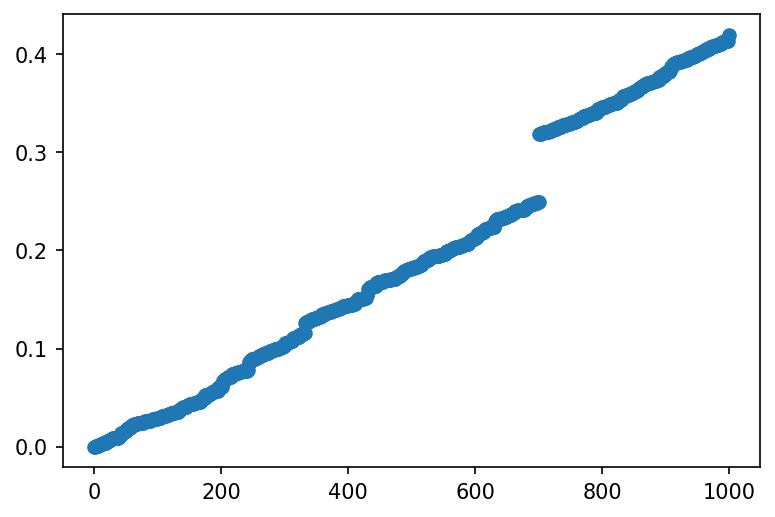

In [ ]:
plt.scatter(np.arange(1000),df["T"][:1000])

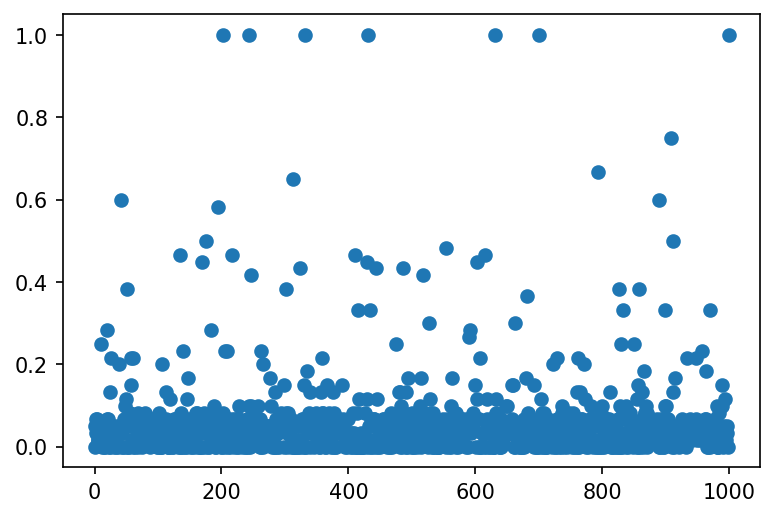

In [ ]:
plt.scatter(np.arange(1000),df["deltaT"][:1000])

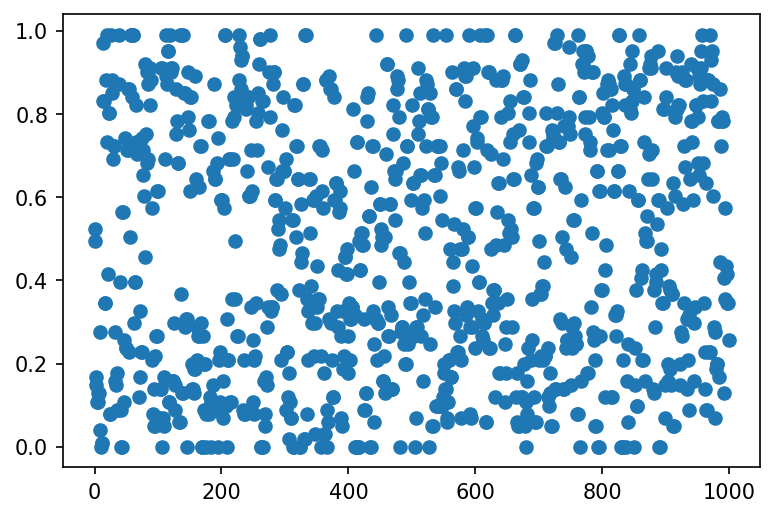

In [ ]:
plt.scatter(np.arange(1000),df["x0"][:1000])

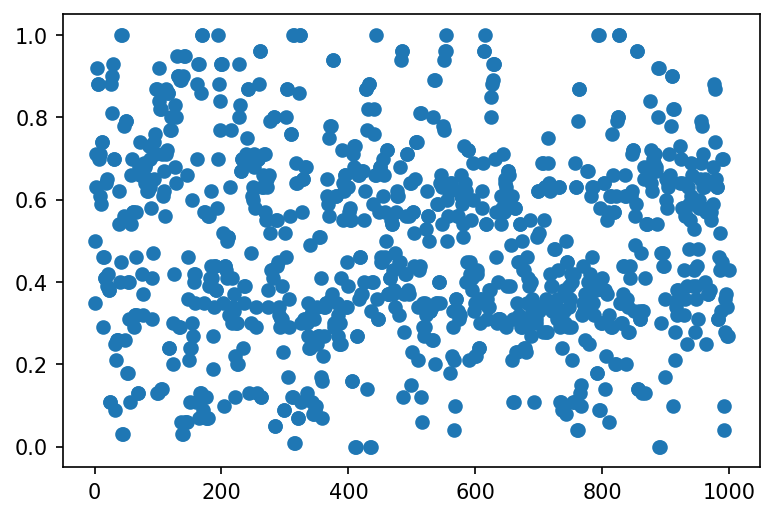

In [ ]:
plt.scatter(np.arange(1000),df["y0"][:1000])

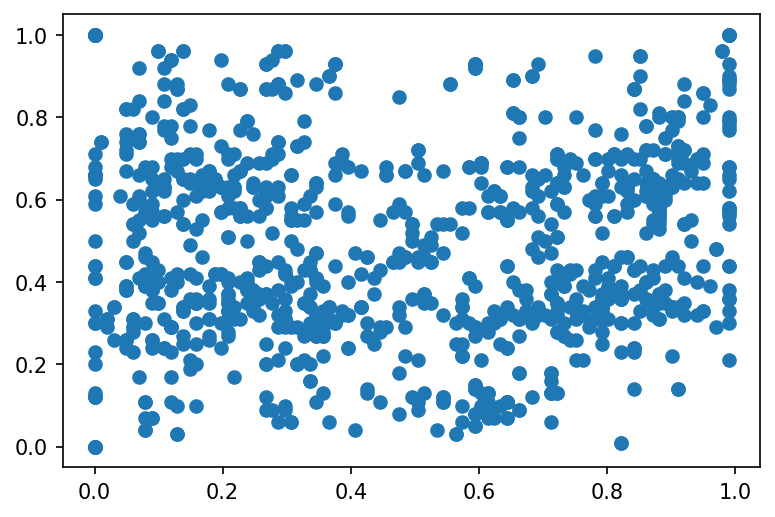

In [ ]:
plt.scatter(df["x0"][:1000],df["y0"][:1000])

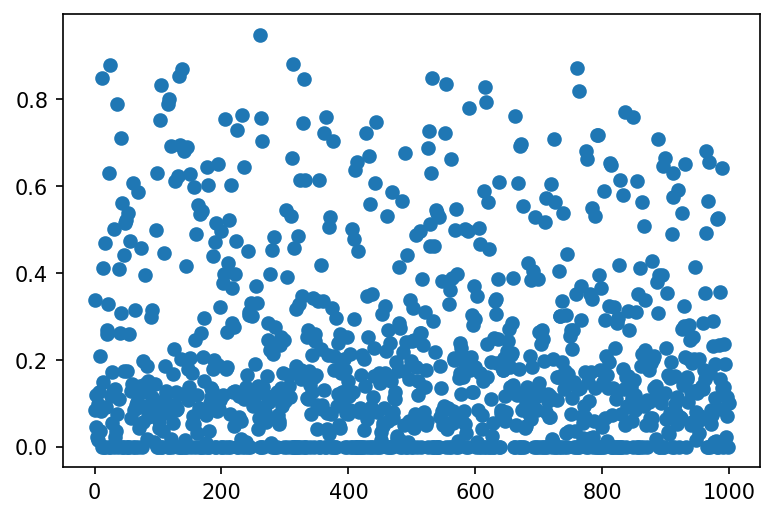

In [ ]:
plt.scatter(np.arange(1000),df["s"][:1000])

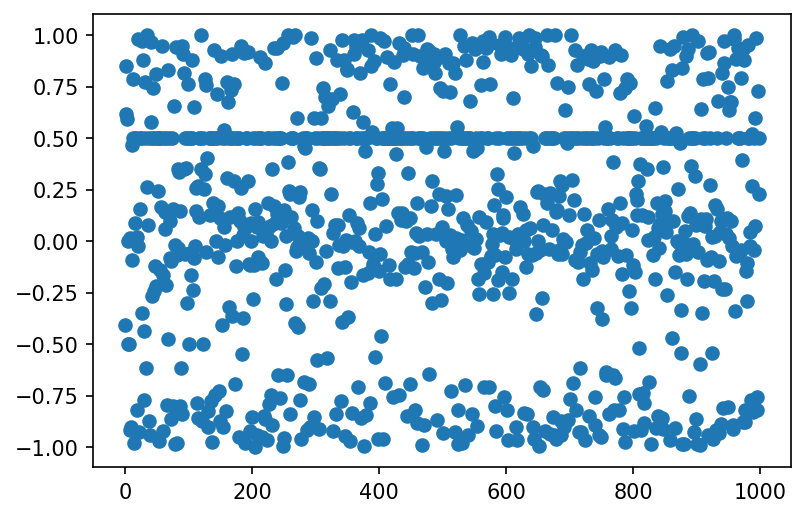

In [ ]:
plt.scatter(np.arange(1000),df["theta"][:1000])

In [ ]:
comps = np.unique(df['comp'])

for i in range(len(comps)):
  print(comps[i])
  print("teams:")
  print(len(np.unique(df.loc[df["comp"] == comps[i],"TID"])))
  print("matches:")
  print(len(np.unique(df.loc[df["comp"] == comps[i],"MID"])))
  print()

WC
teams:
32
matches:
64



#Visualise

(<Figure size 2100x750 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d29c9da10>)

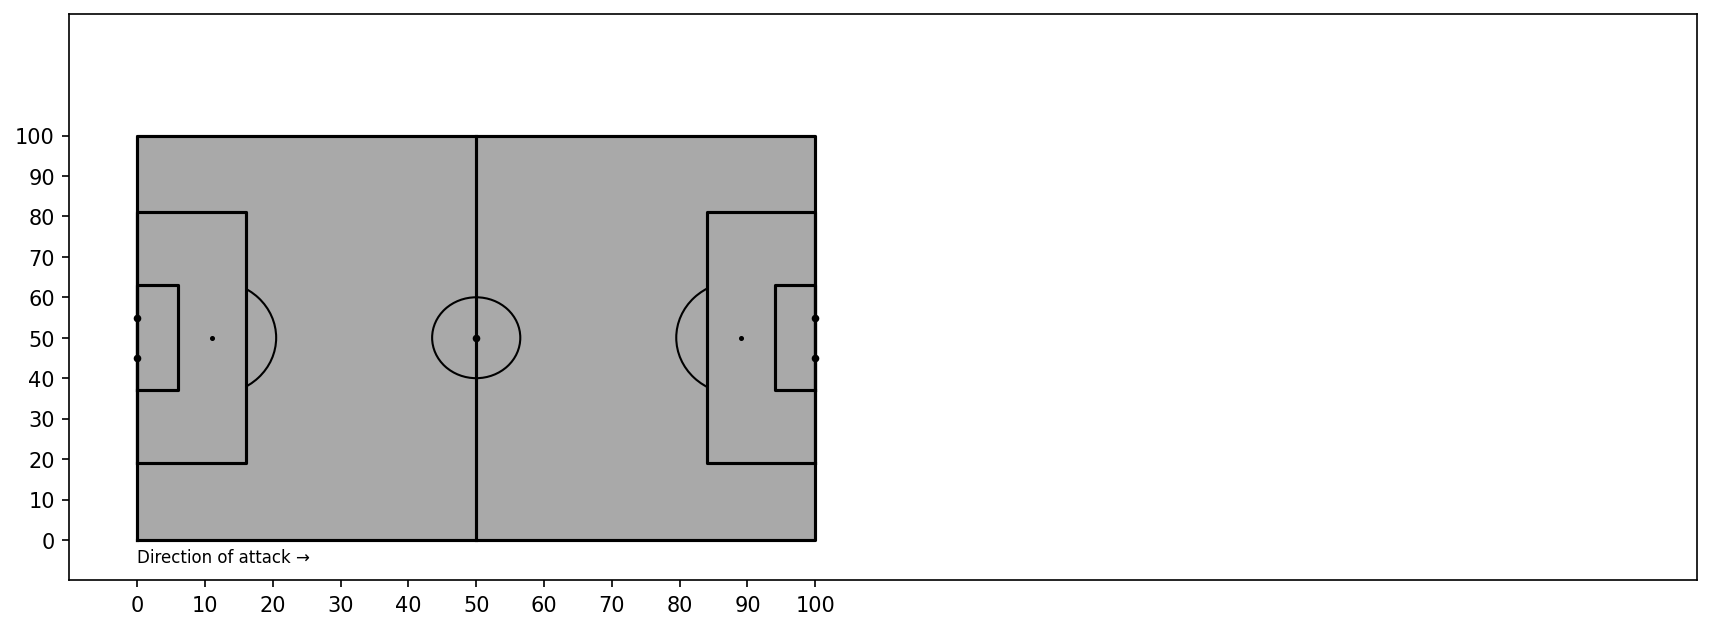

In [ ]:
#Setup a soccer plot
def setup_soccerplot(include_labels=True,figsize=(14,5),xlim_max=230):
  fig, ax = plt.subplots(figsize=figsize)
  #ax.grid(); ax.set_axisbelow(True)
  #ax.set_facecolor("#7a7a7a")
  ax.set_xlim(-10,xlim_max); ax.set_ylim(-10,130)
  ax.set_xticks(np.arange(0, 101, step=10))
  ax.set_yticks([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
  ax.plot([0,100,100,0,0],[0,0,100,100,0],color="black")
  ax.plot([50,50],[0,100],color="black")

  ax.plot([0,16,16,0,0],[19,19,81,81,19],color="black")
  ax.plot([0,6,6,0,0],[37,37,63,63,37],color="black")

  ax.add_patch(mpatches.Rectangle((0,19),16,62,fill=True,color="darkgrey",zorder=-1))
  ax.add_patch(mpatches.Rectangle((84,19),16,62,fill=True,color="darkgrey",zorder=-1))
  ax.plot([100,84,84,100,100],[19,19,81,81,19],color="black")
  ax.plot([100,94,94,100,100],[37,37,63,63,37],color="black")
  import matplotlib
  ax.add_patch(matplotlib.patches.Ellipse((11.5,50),18,28,fill=False,zorder=-2))
  ax.add_patch(matplotlib.patches.Ellipse((88.5,50),18,28,fill=False,zorder=-2))
  ax.add_patch(matplotlib.patches.Ellipse((50,50),13,20,fill=False))
  ax.add_patch(mpatches.Rectangle((0,0),100,100,fill=True,color="darkgrey",zorder=-3))

  ax.scatter(11,50,zorder=2,color="black",s=2)
  ax.scatter(89,50,zorder=2,color="black",s=2)
  ax.scatter(0,55,zorder=2,color="black",s=7)
  ax.scatter(0,45,zorder=2,color="black",s=7)
  ax.scatter(100,55,zorder=2,color="black",s=7)
  ax.scatter(100,45,zorder=2,color="black",s=7)
  ax.scatter(50,50,zorder=2,color="black",s=7)

  if include_labels:
    ax.text(0,-2,verticalalignment='top',horizontalalignment='left',fontsize=8,s="Direction of attack →",color="black")
  return fig, ax
setup_soccerplot(include_labels=True)

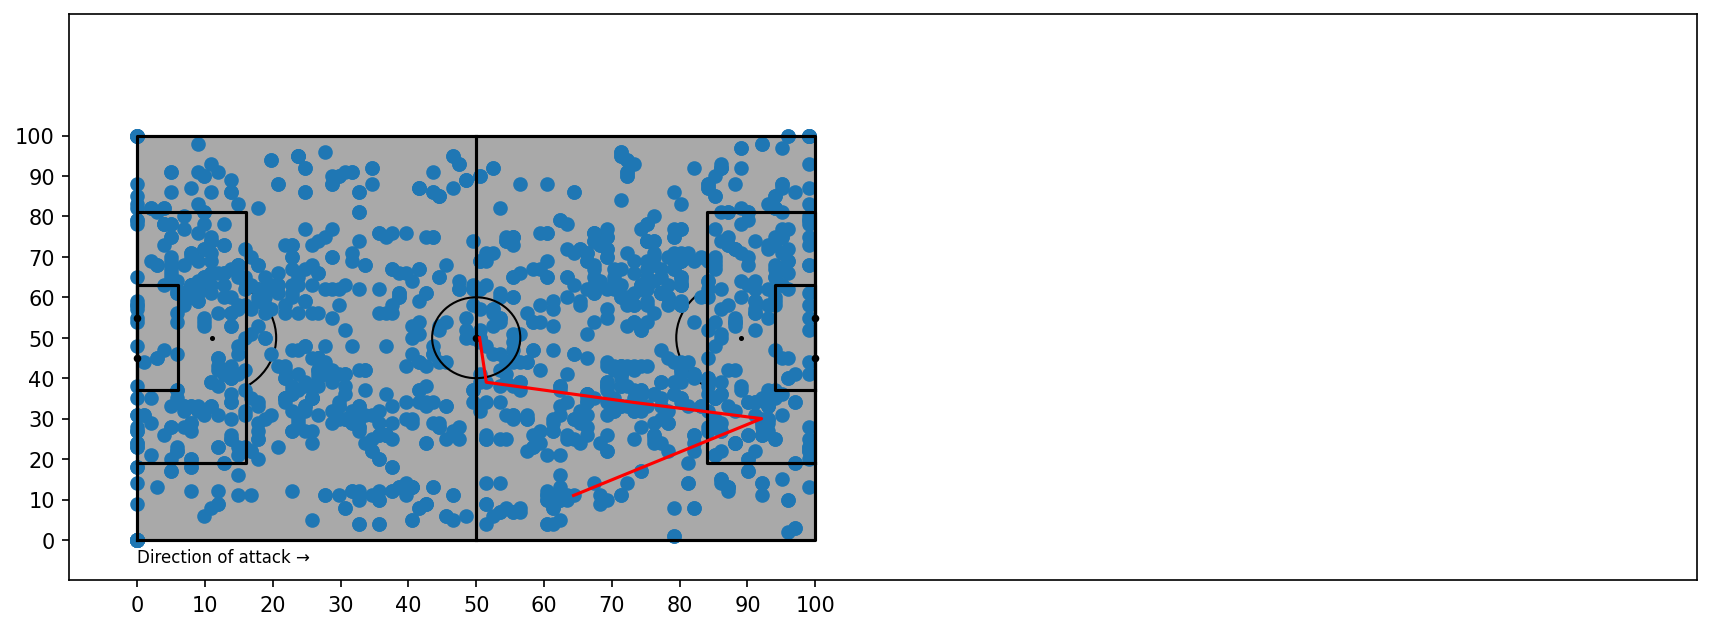

In [ ]:
temp0 = df.loc[df["MID"] == 2058017,:]

fig, ax = setup_soccerplot(include_labels=True)
ax.scatter(temp0['x0']*100,temp0['y0']*100)
ax.plot(temp0['x0'][:5]*100,temp0['y0'][:5]*100,color="red")

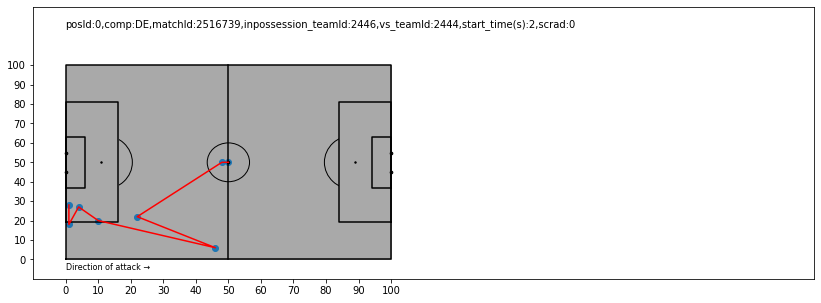

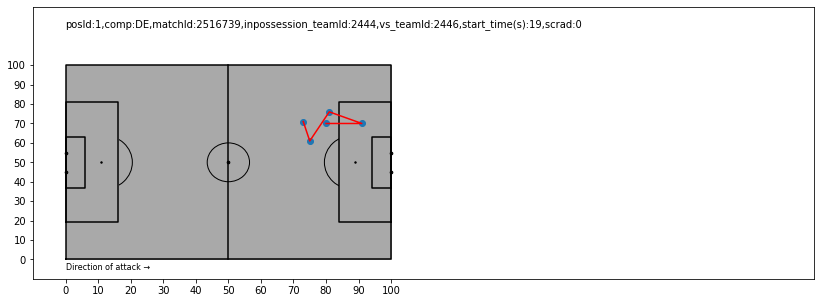

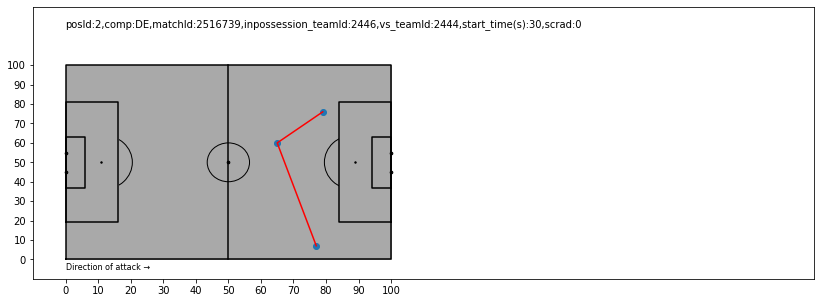

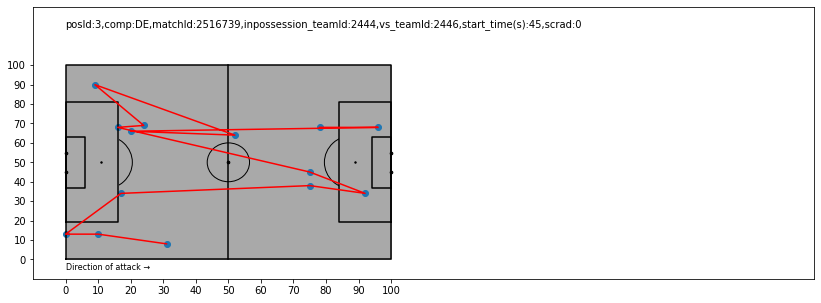

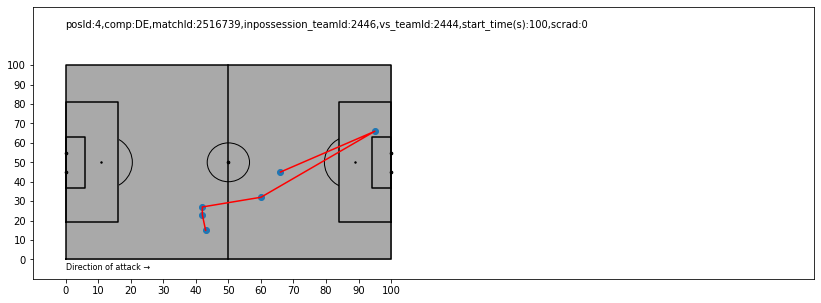

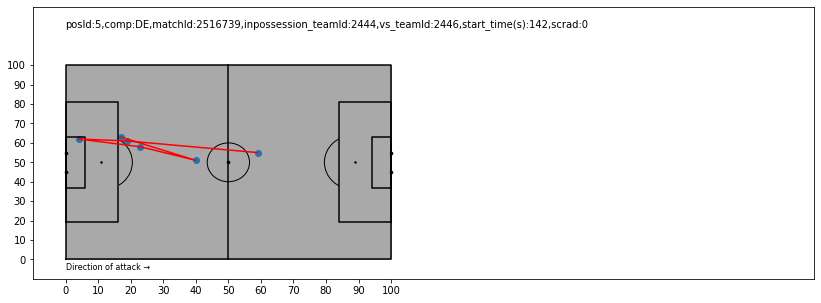

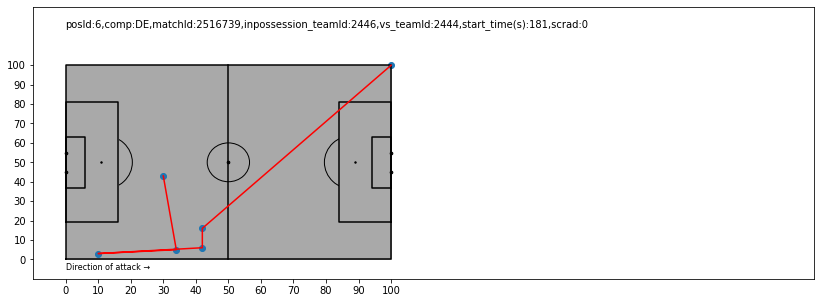

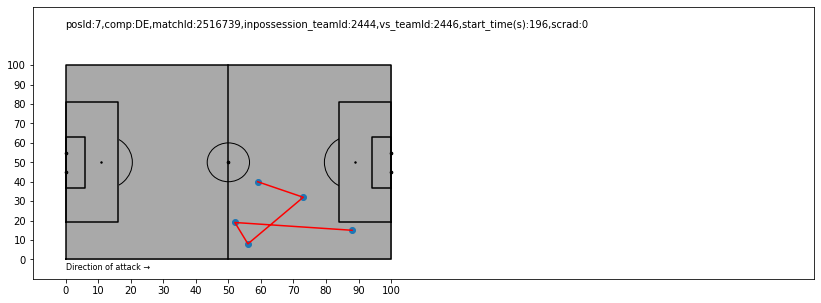

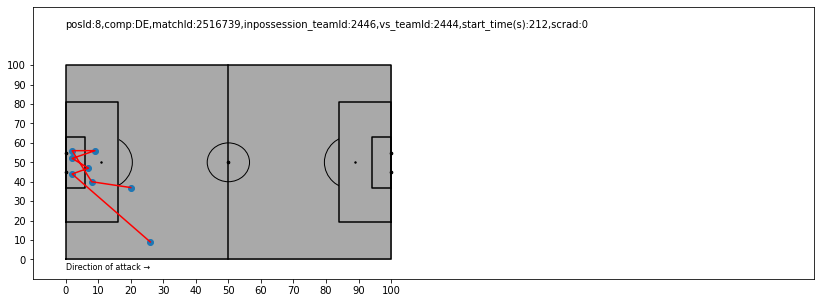

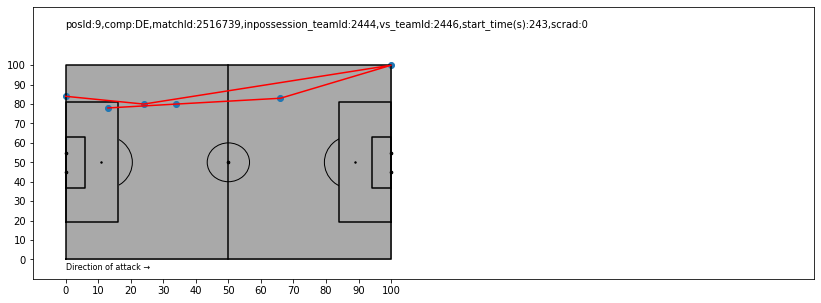

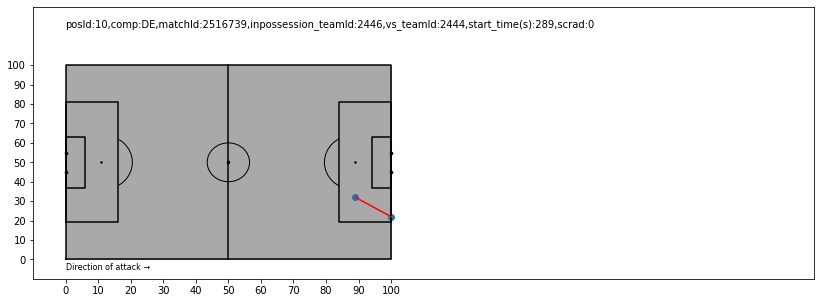

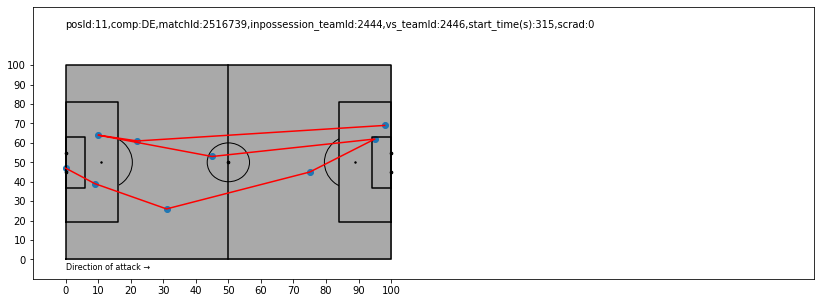

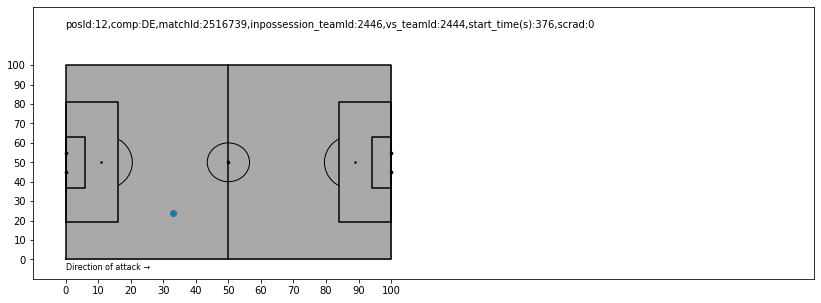

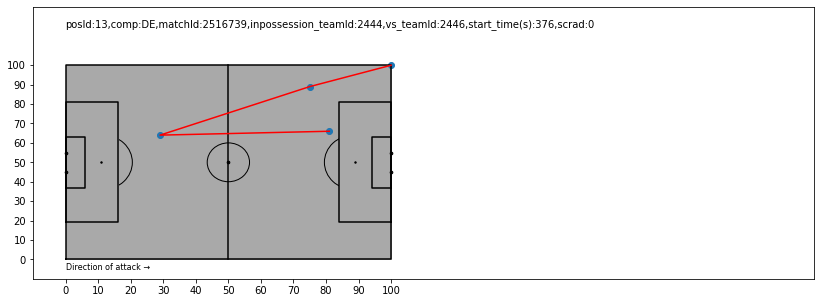

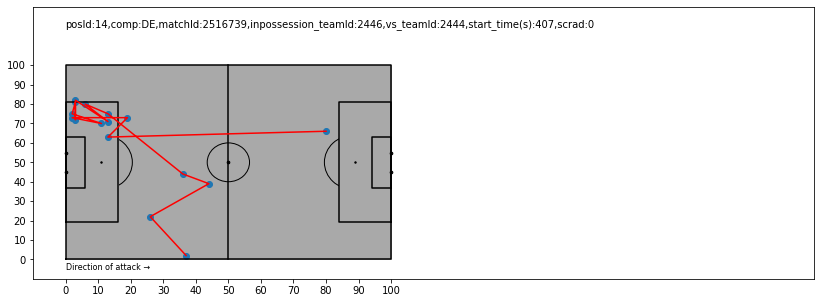

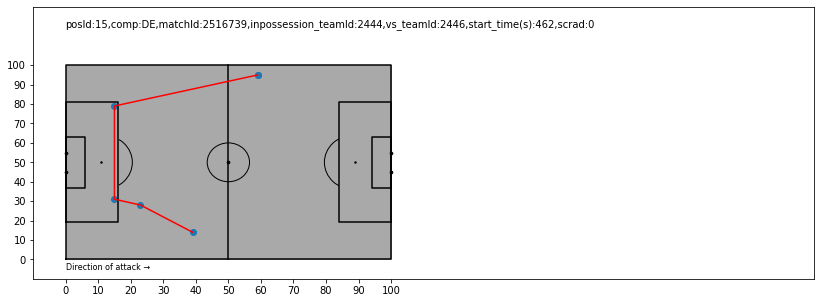

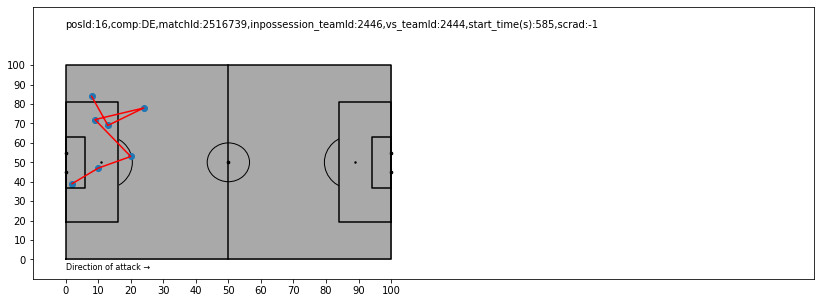

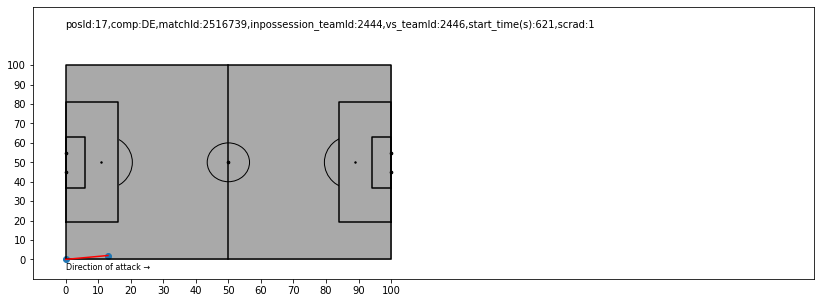

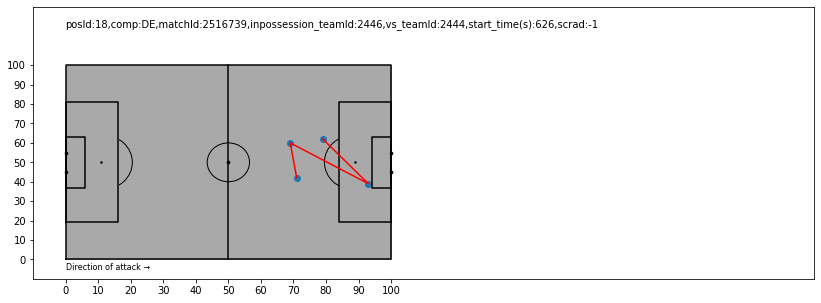

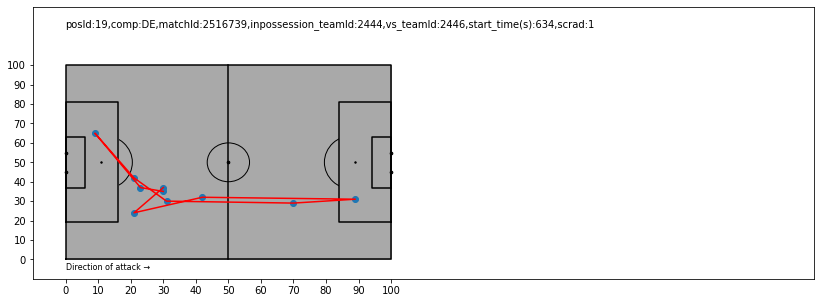

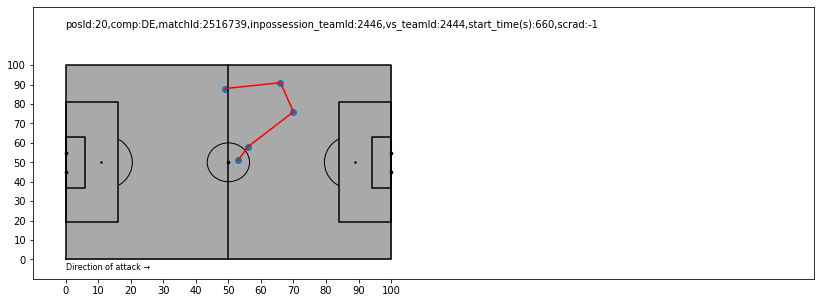

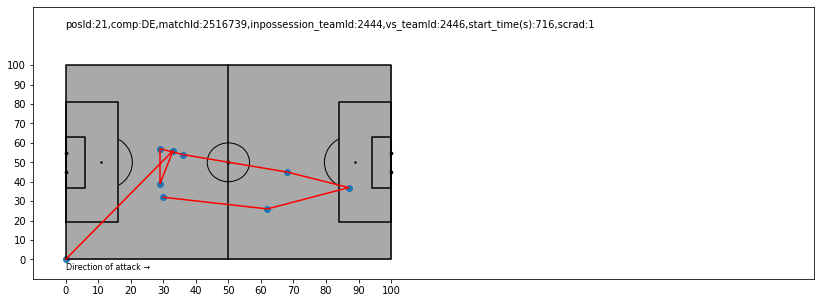

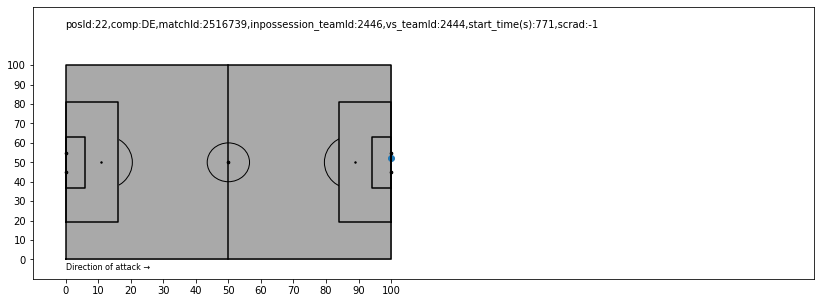

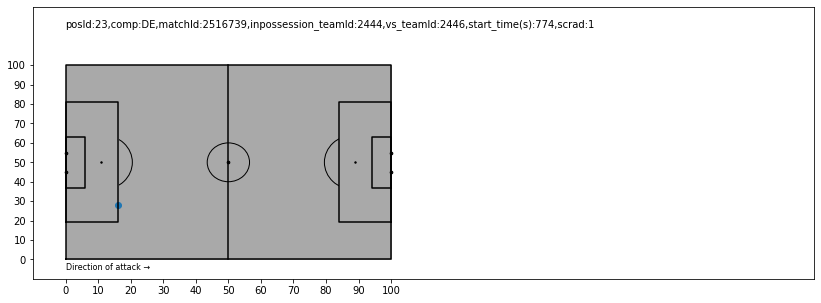

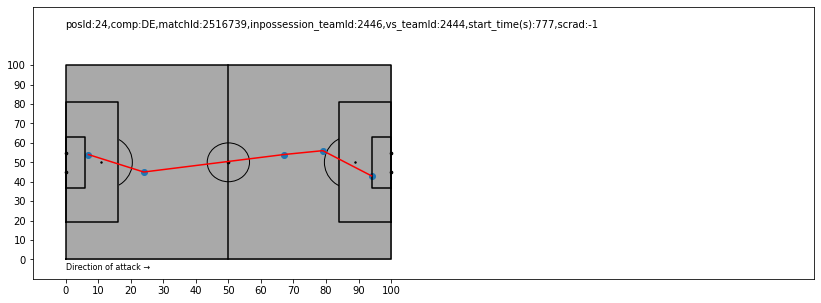

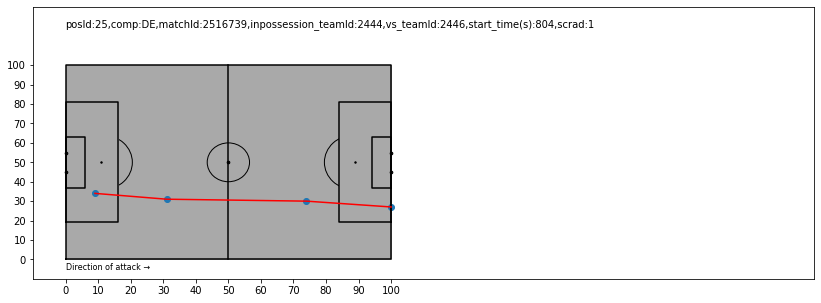

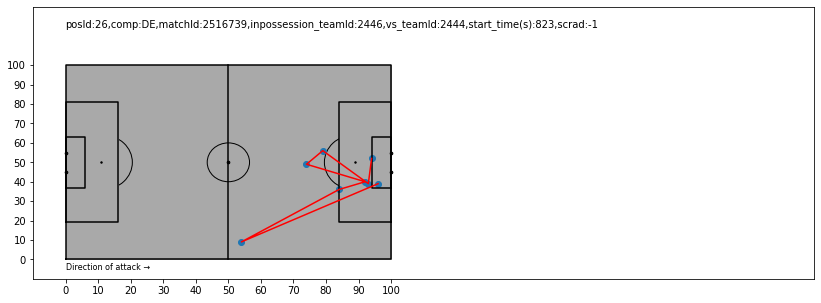

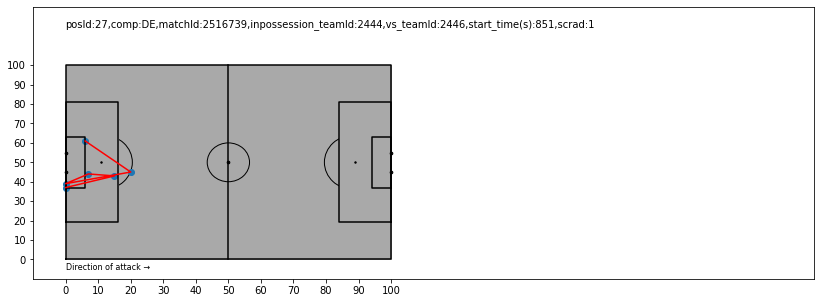

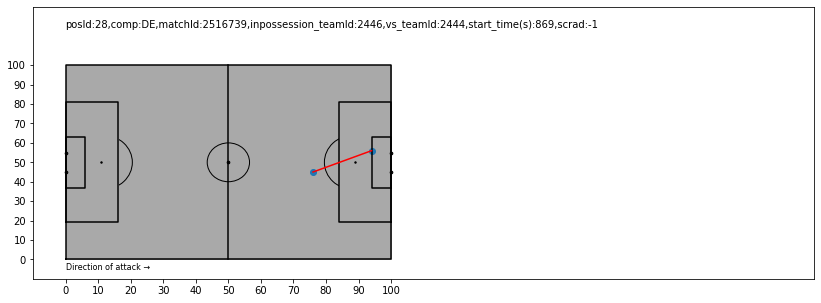

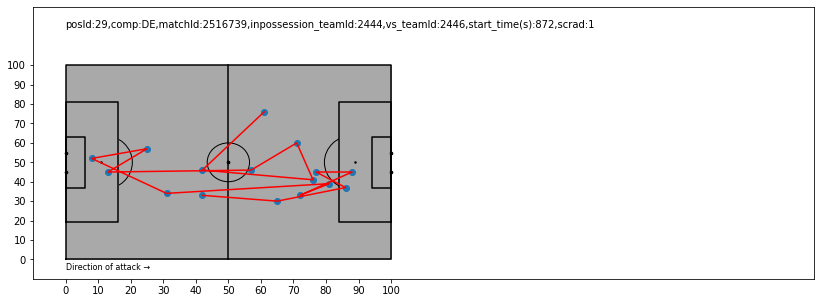

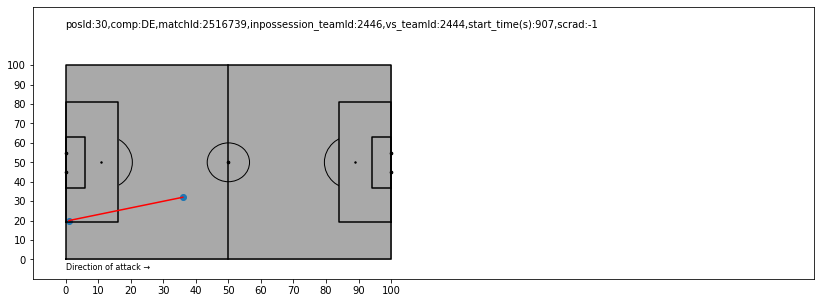

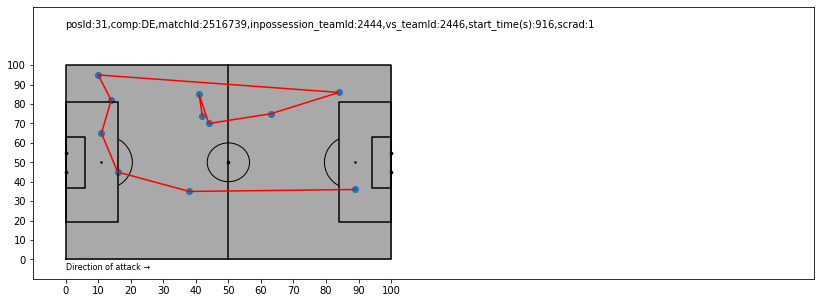

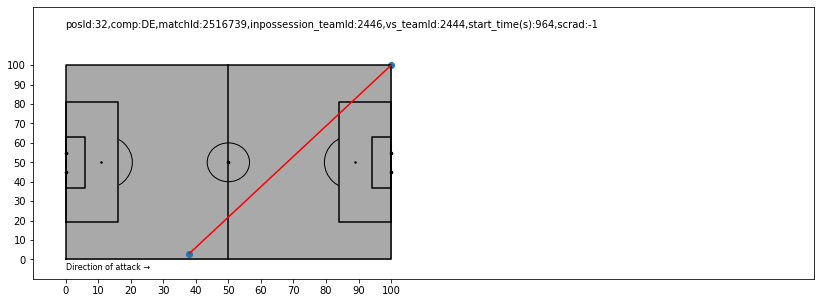

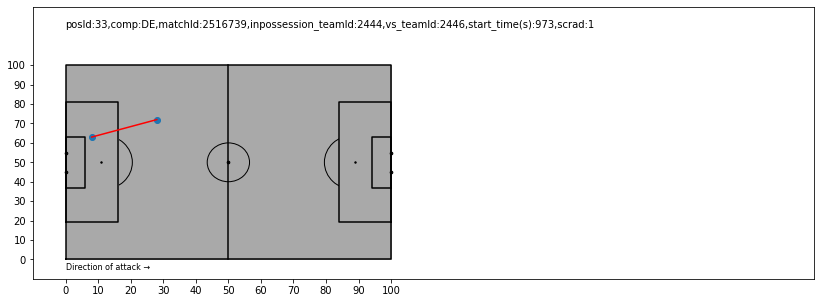

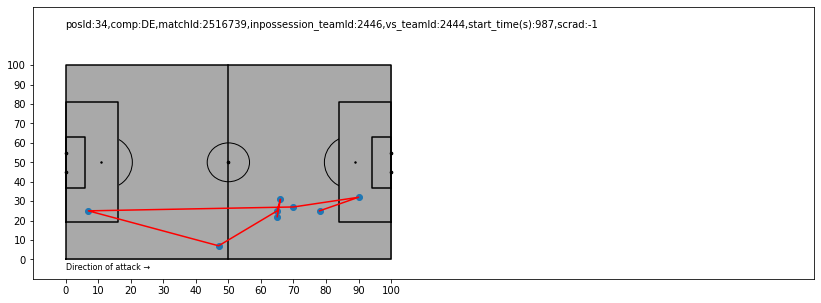

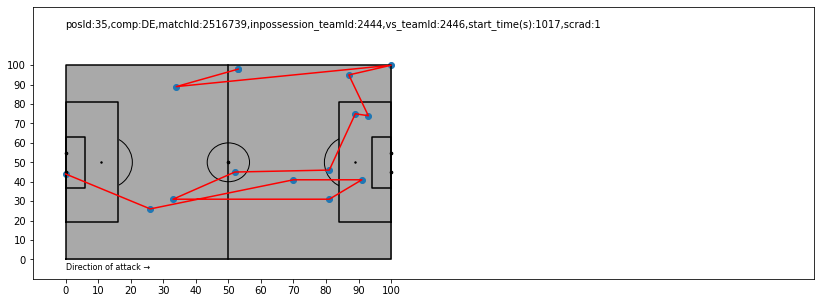

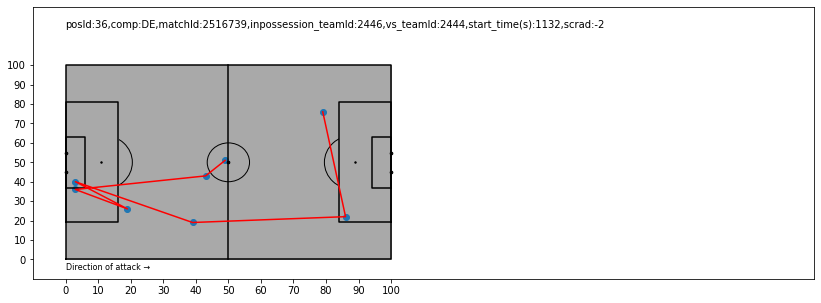

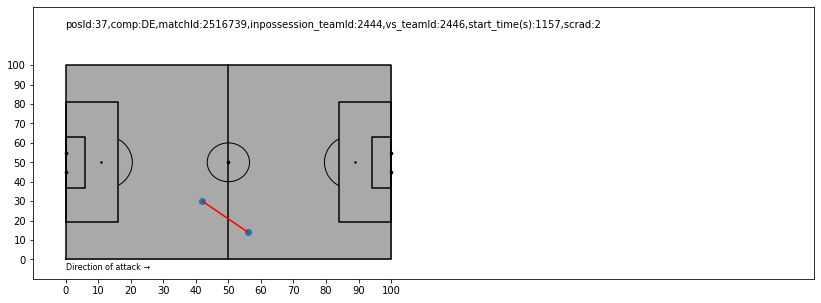

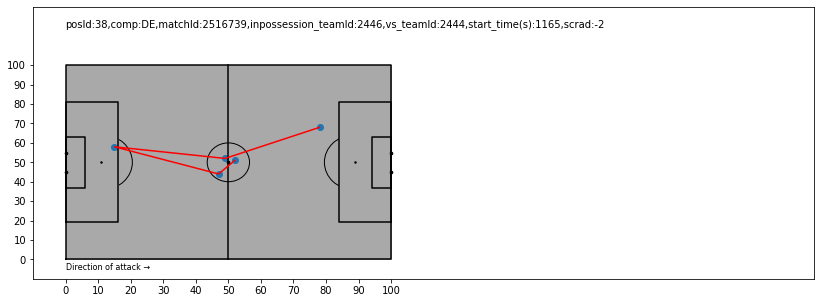

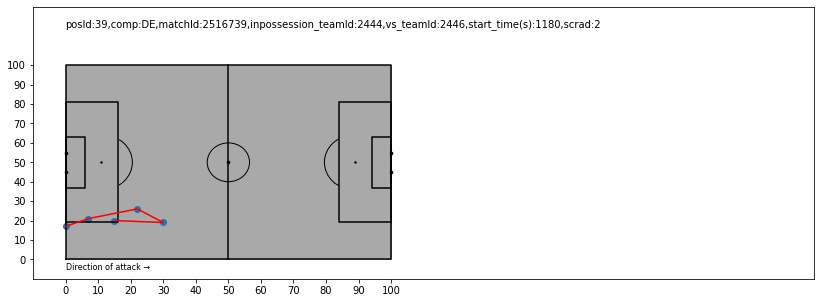

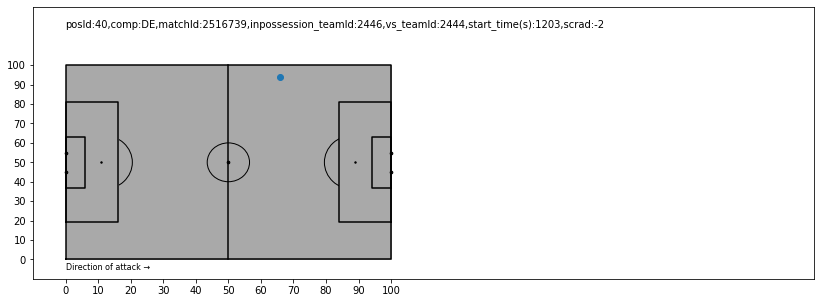

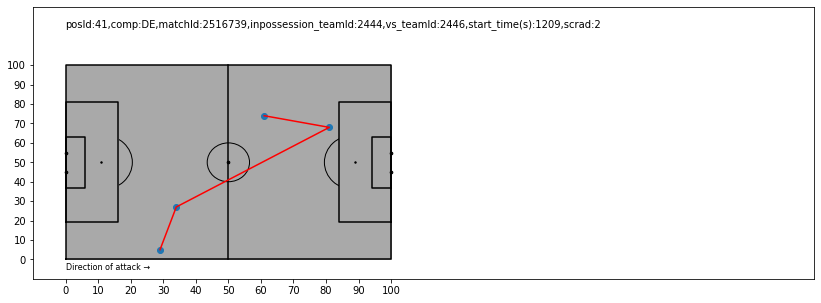

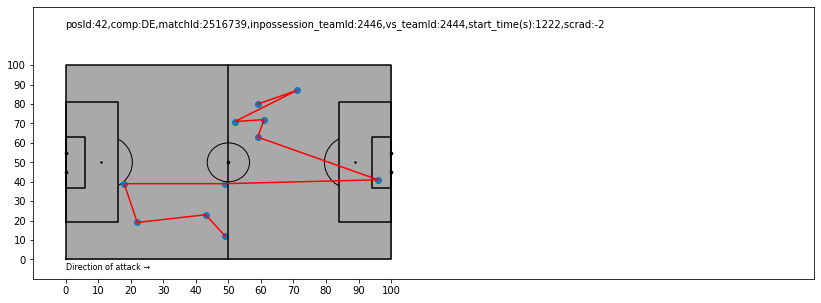

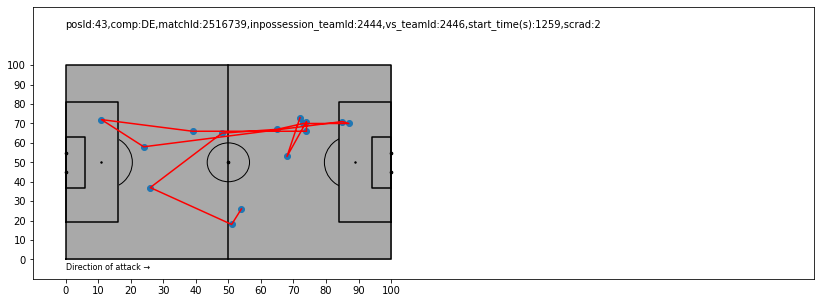

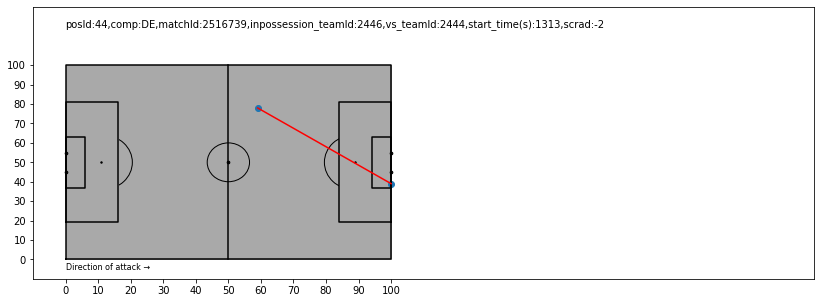

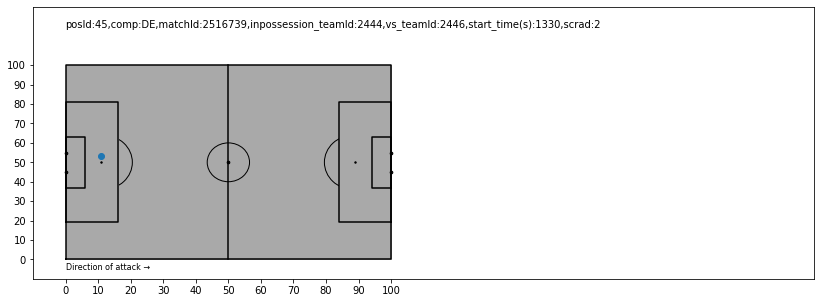

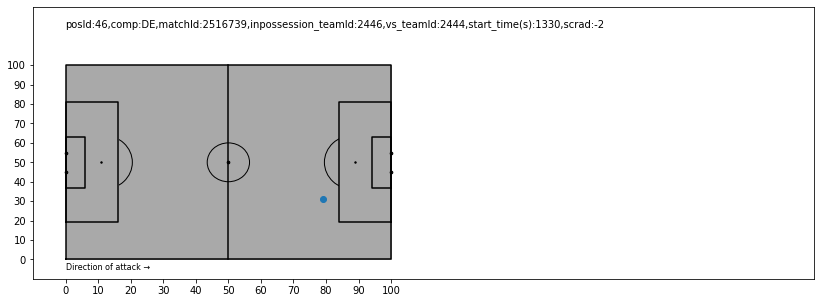

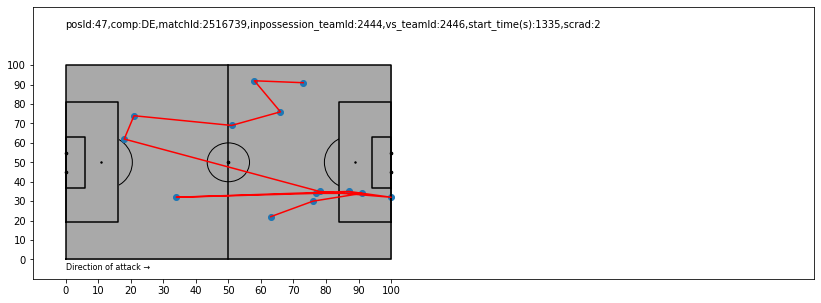

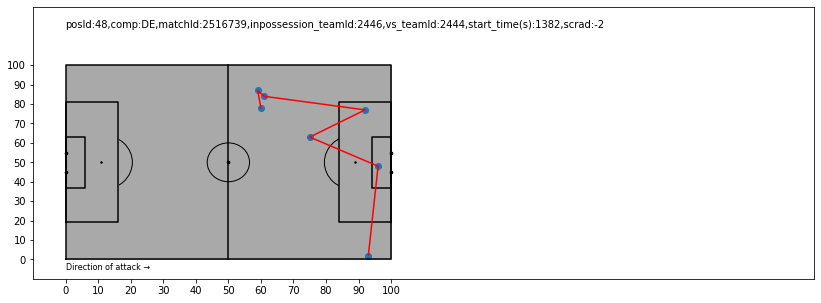

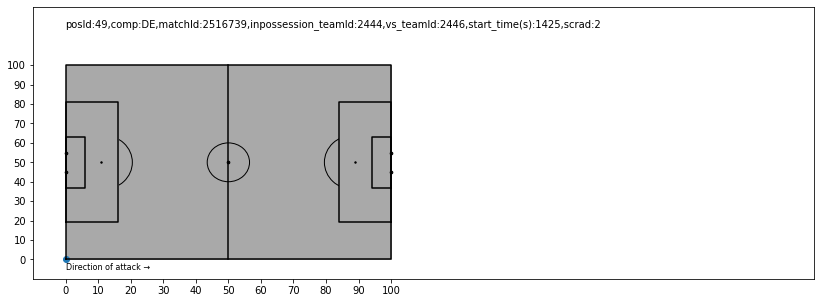

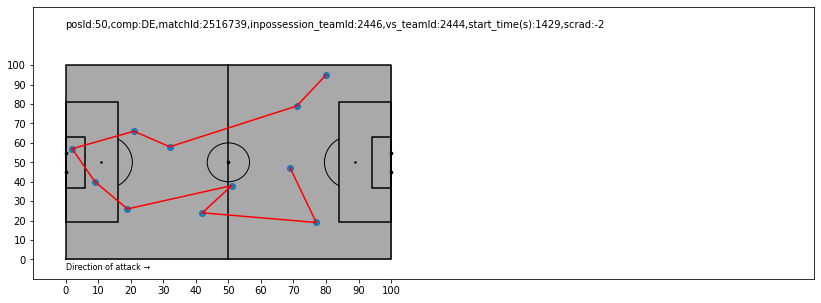

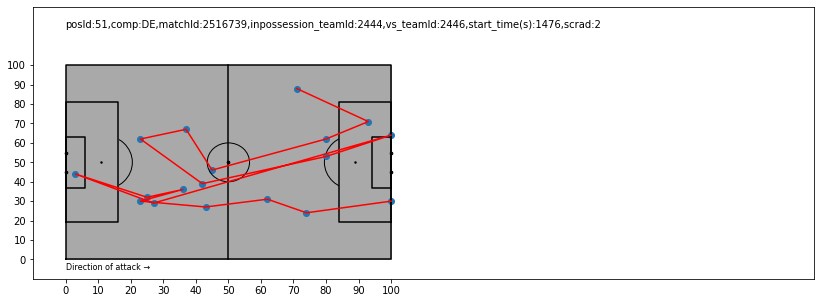

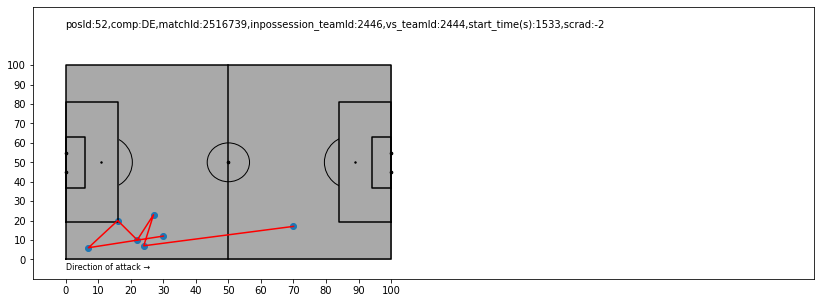

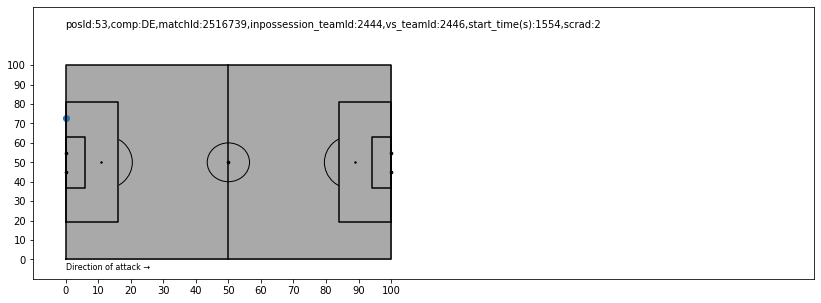

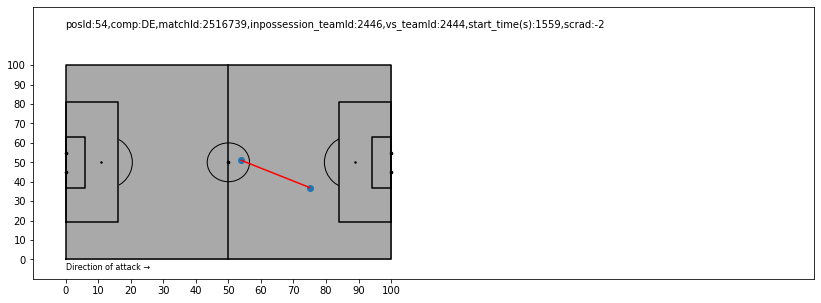

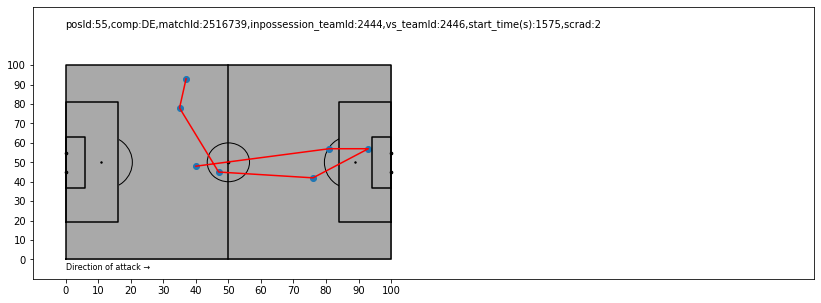

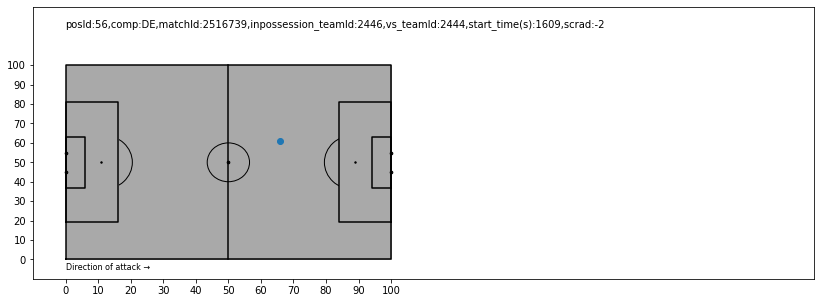

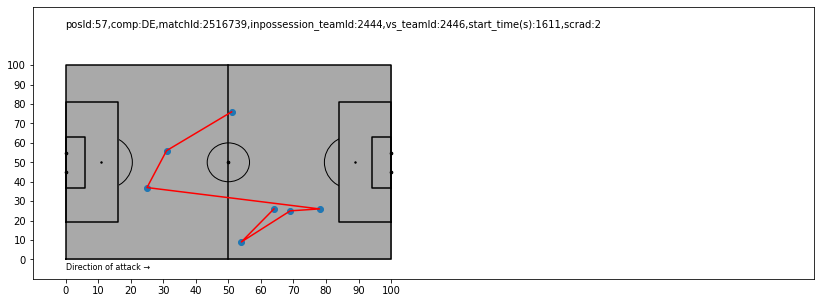

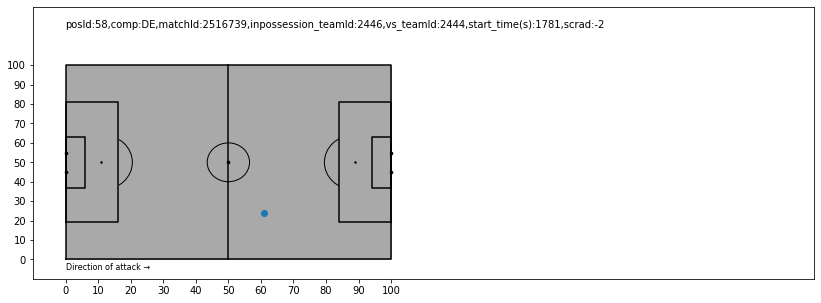

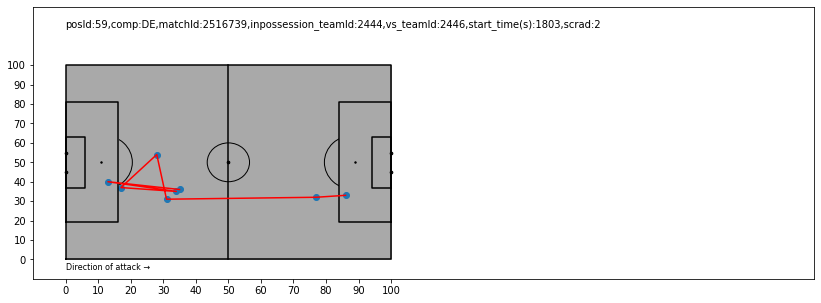

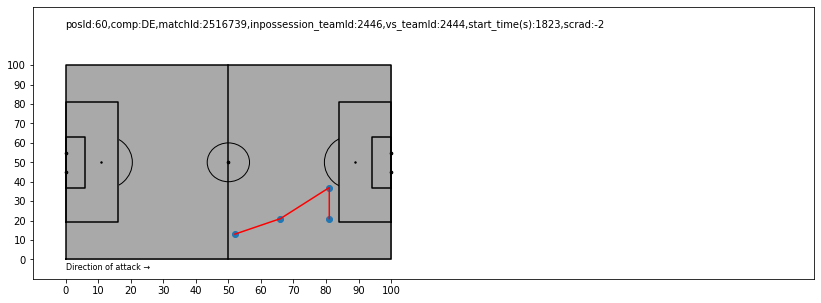

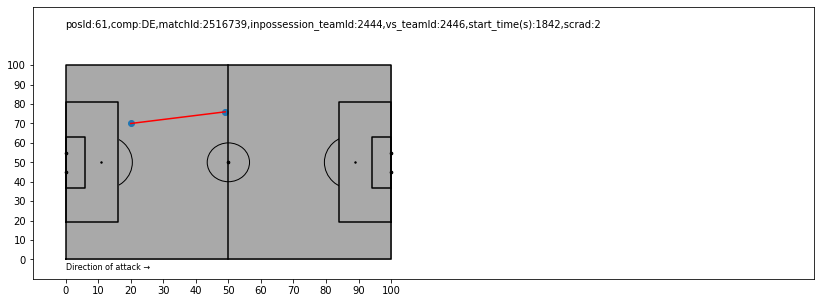

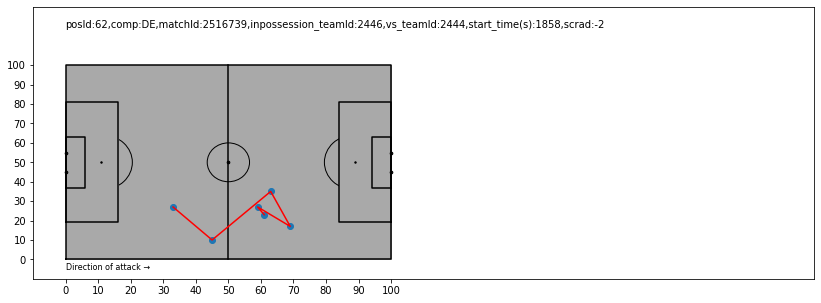

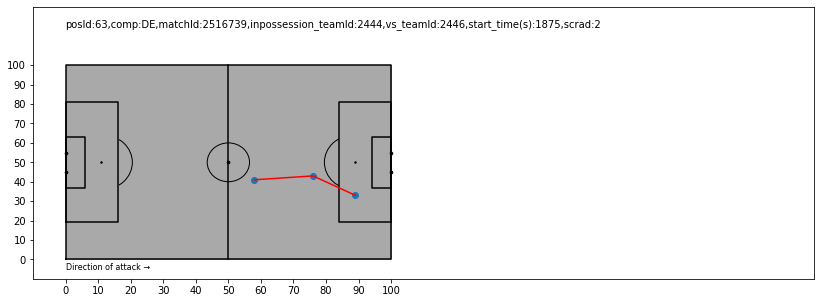

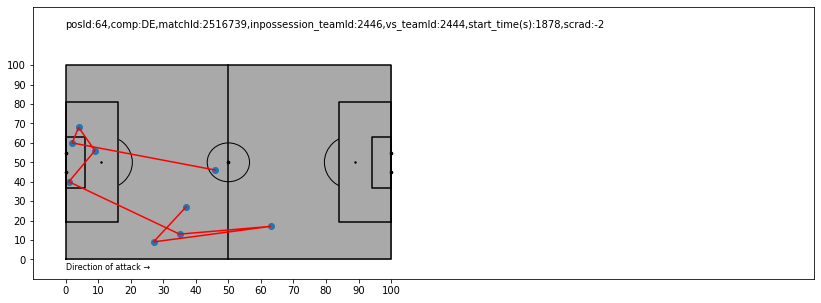

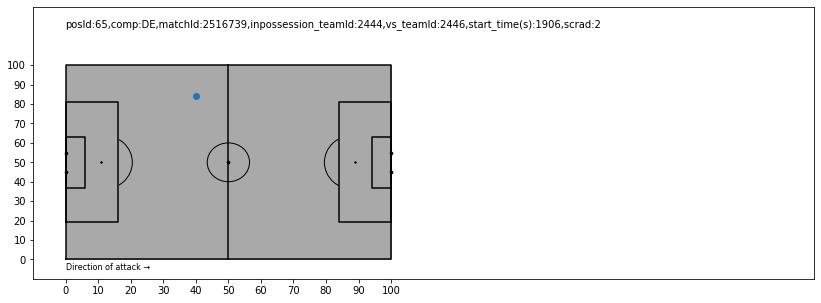

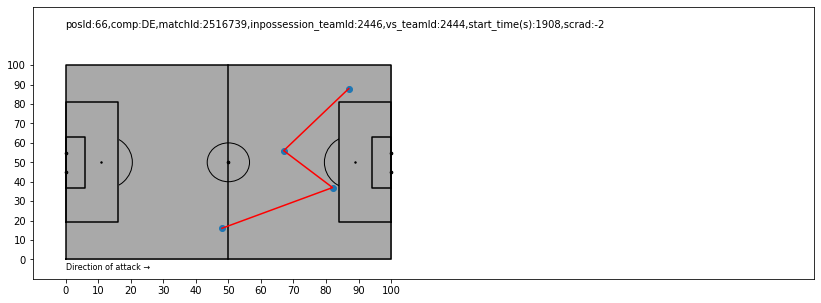

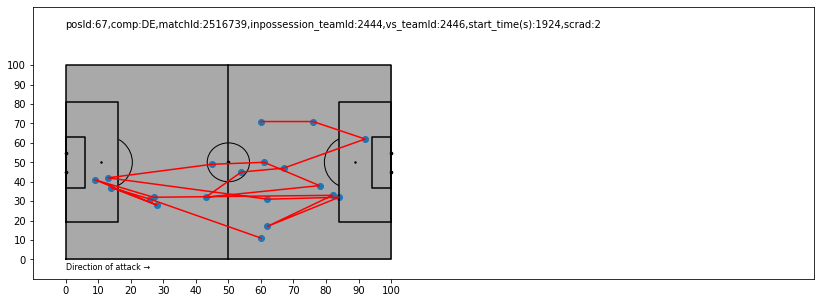

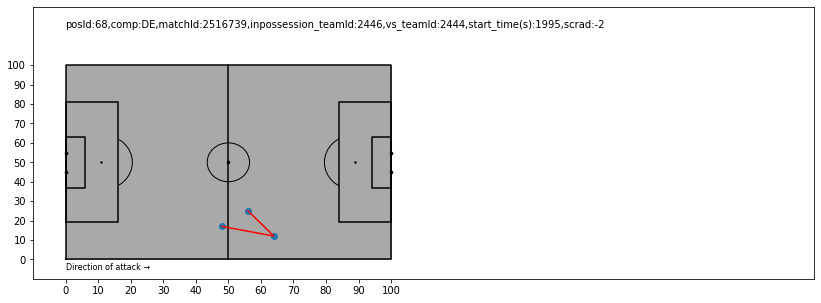

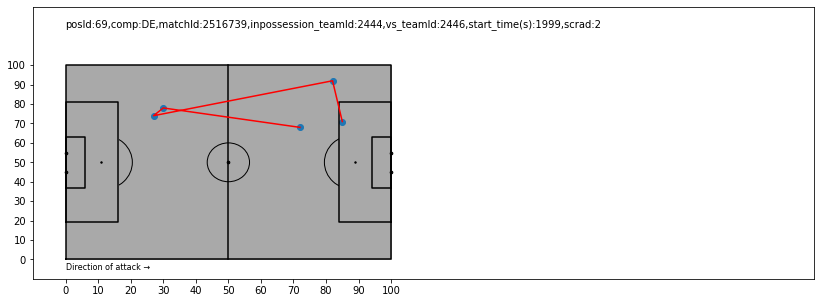

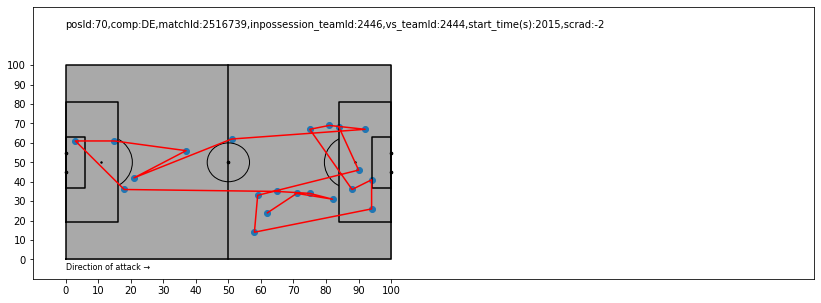

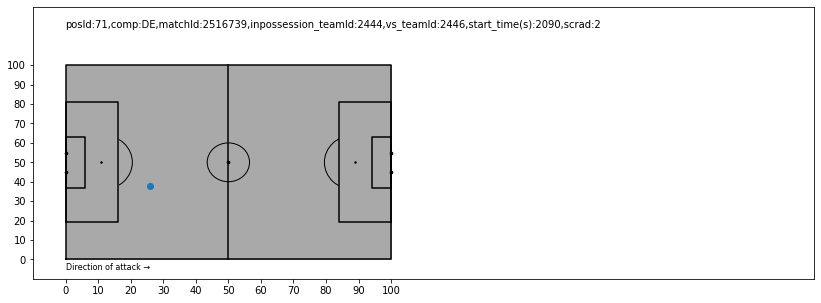

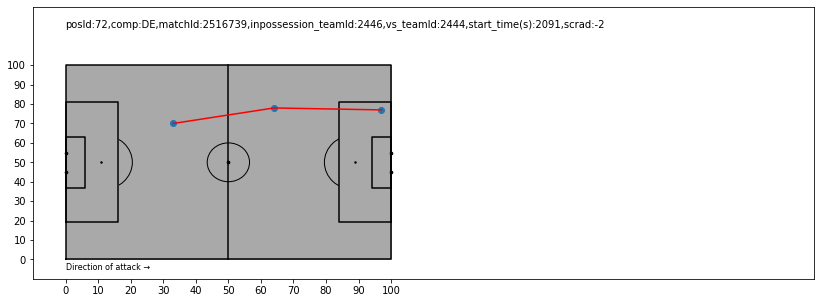

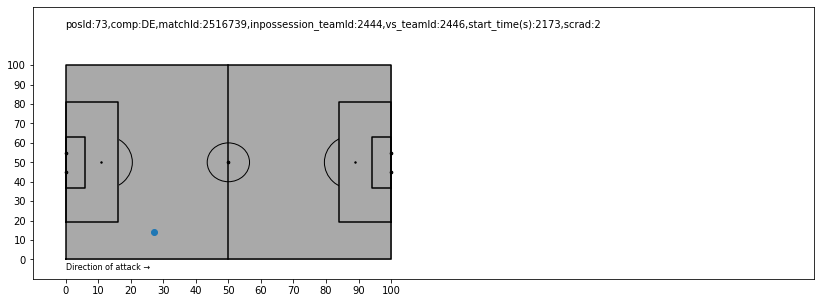

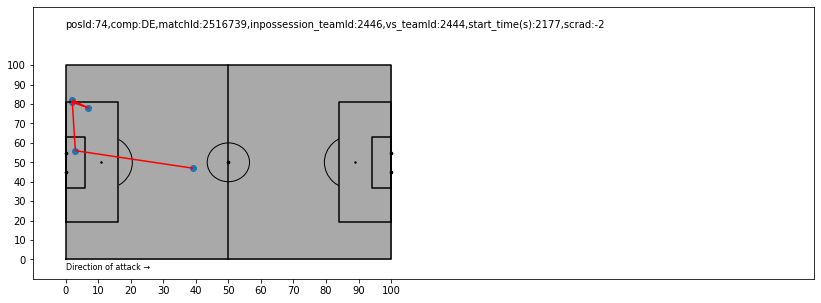

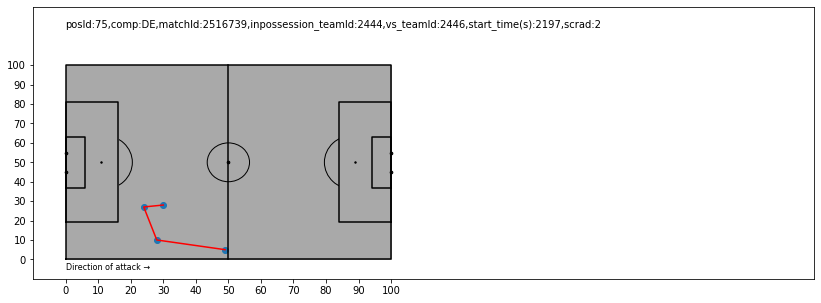

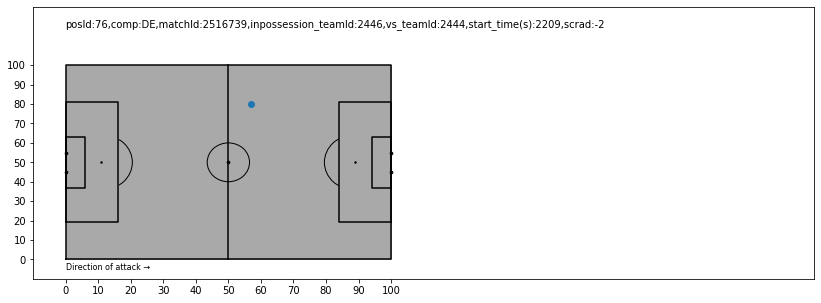

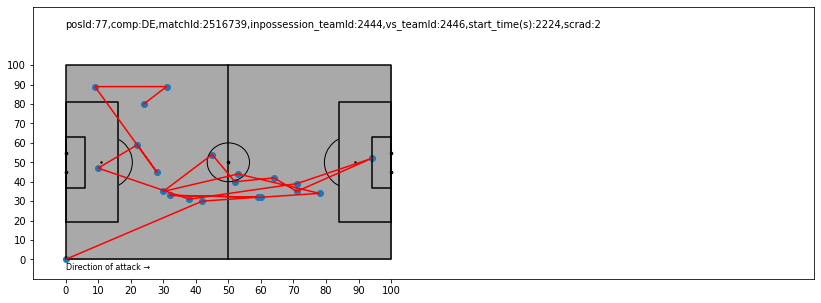

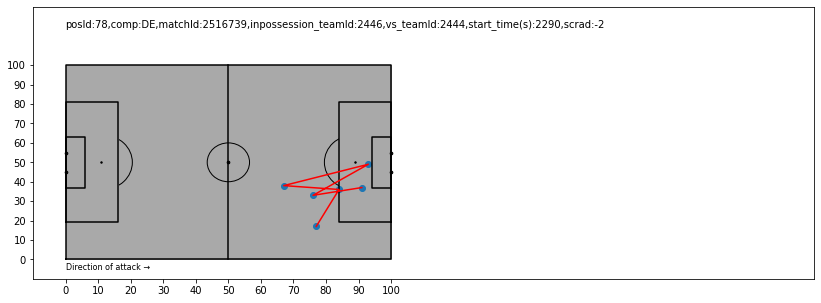

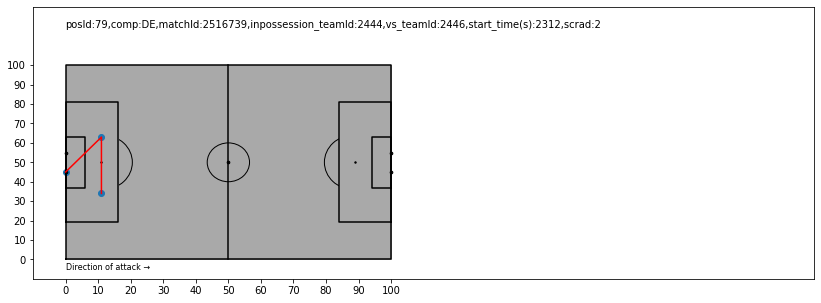

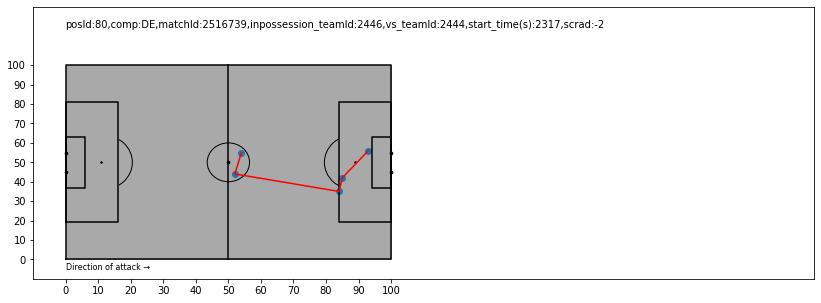

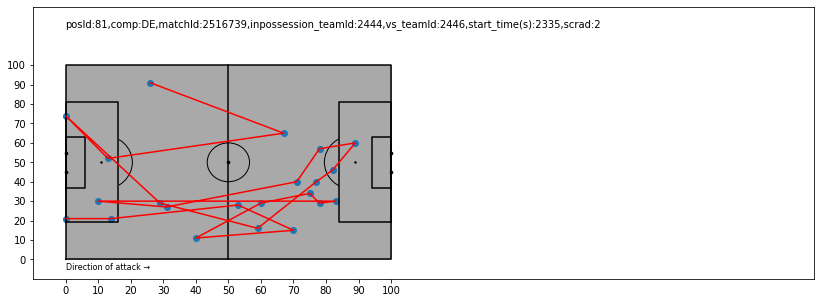

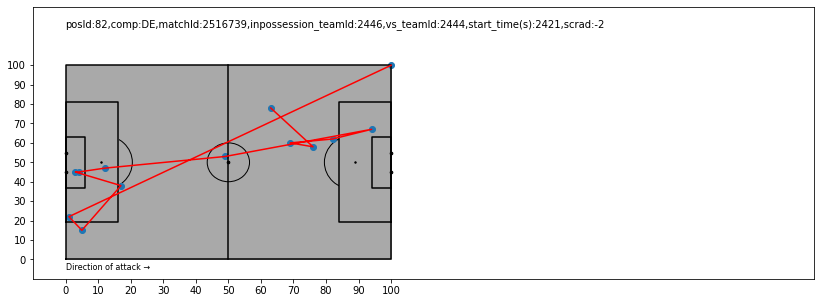

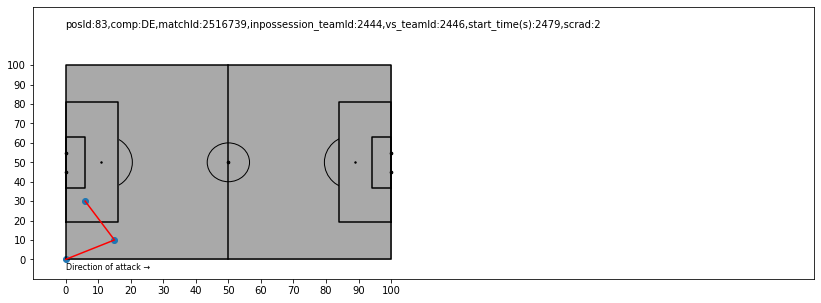

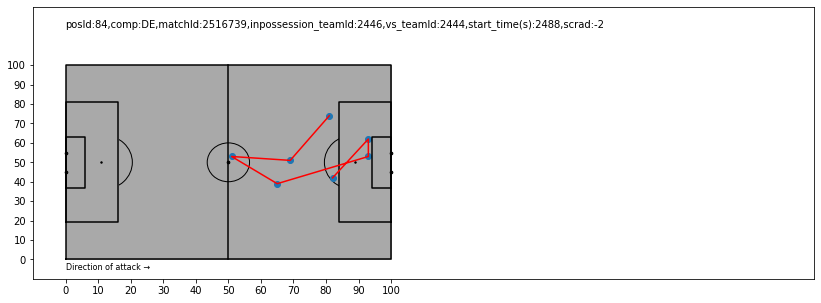

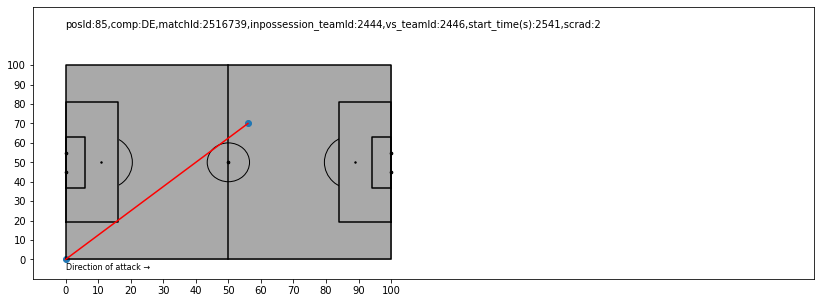

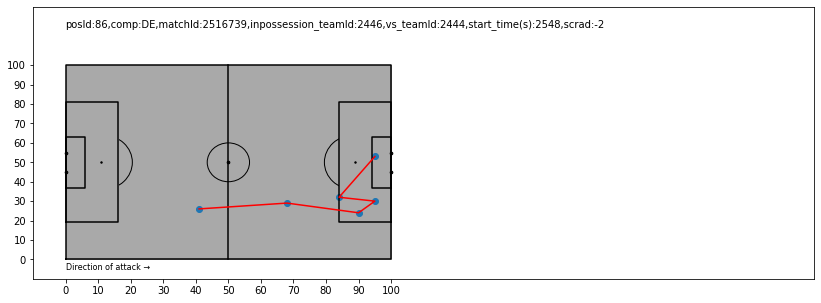

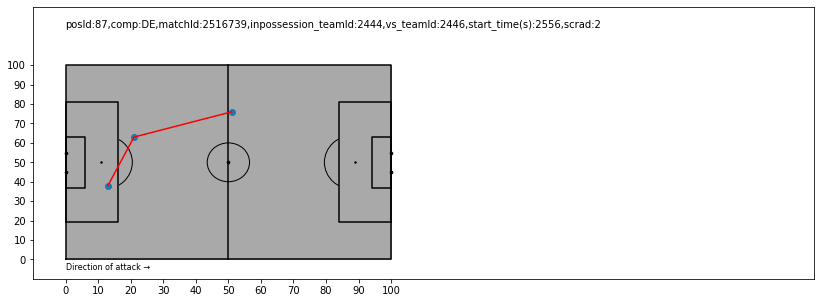

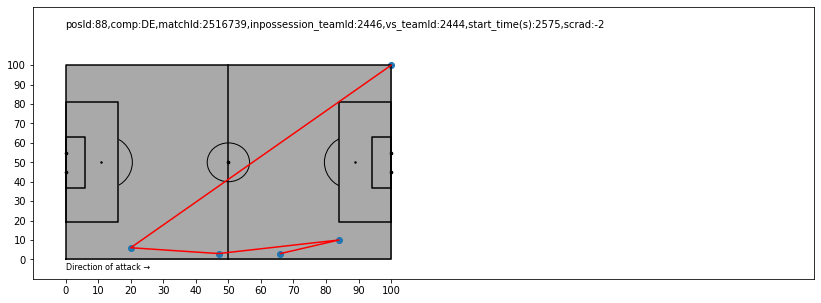

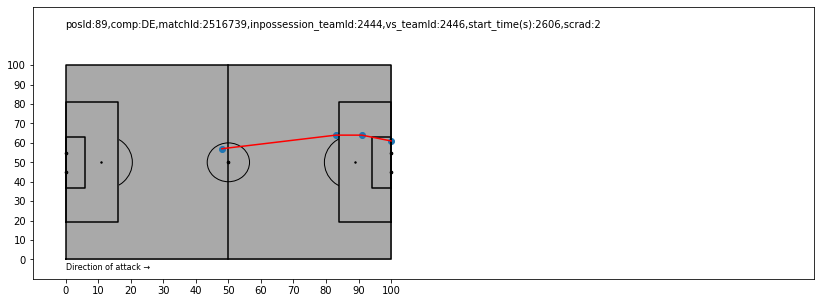

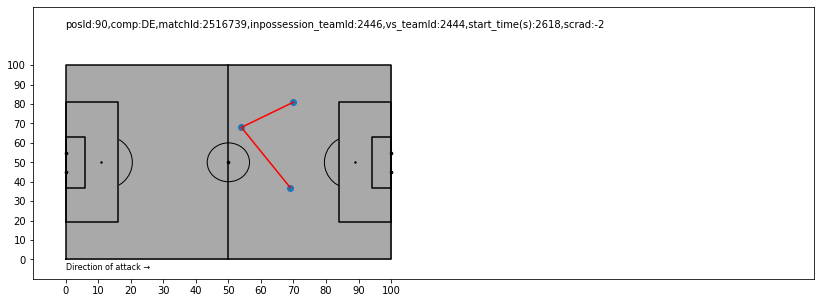

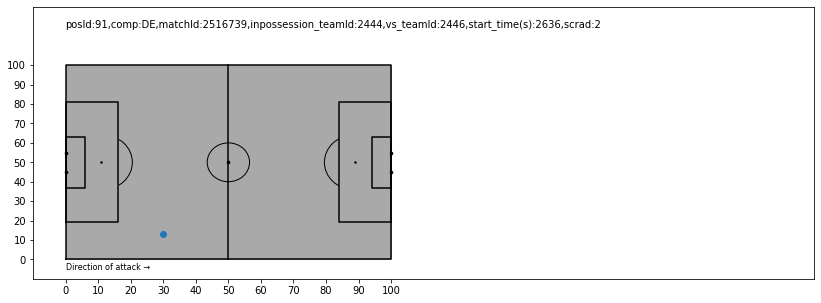

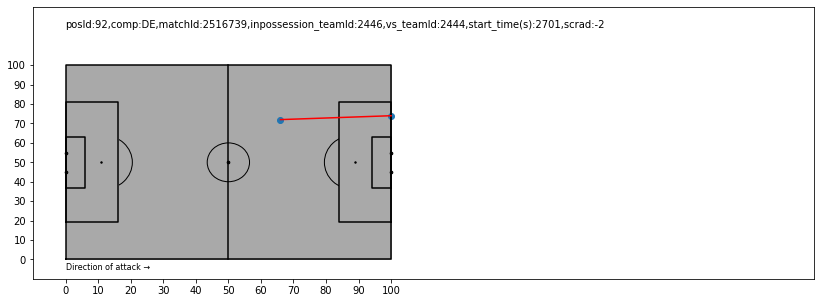

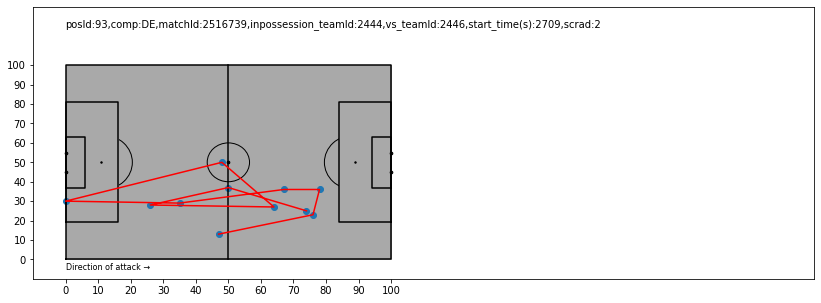

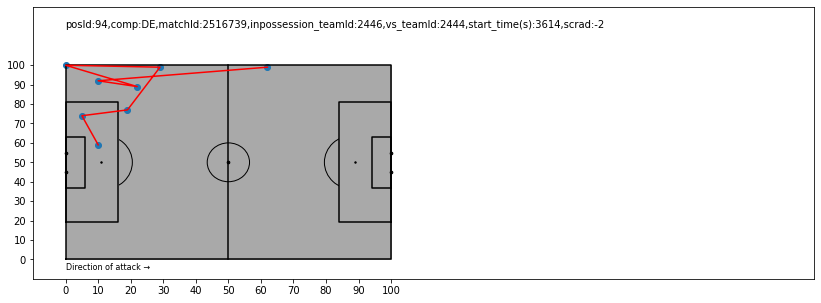

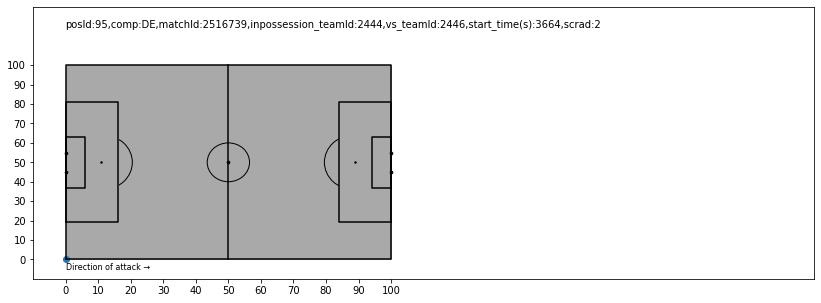

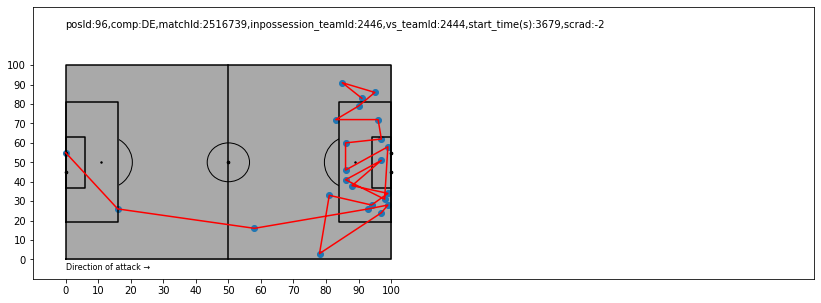

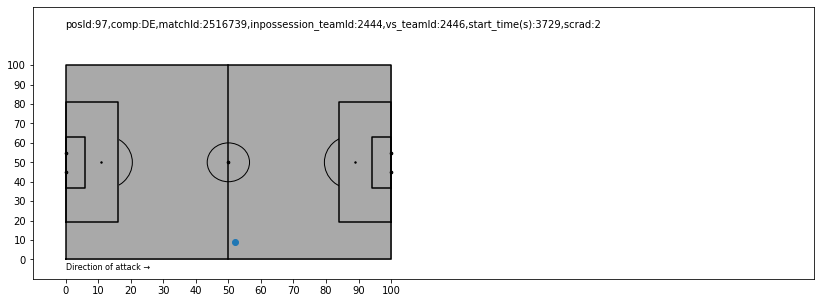

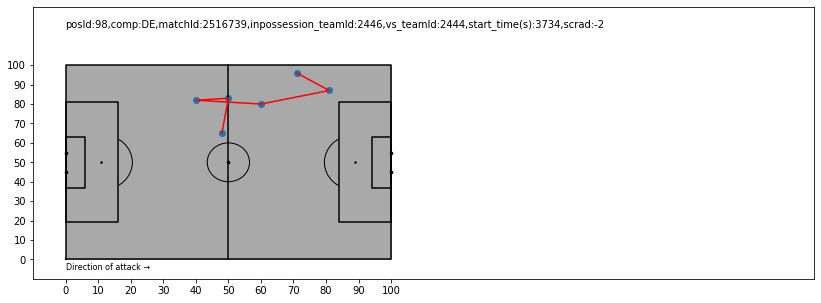

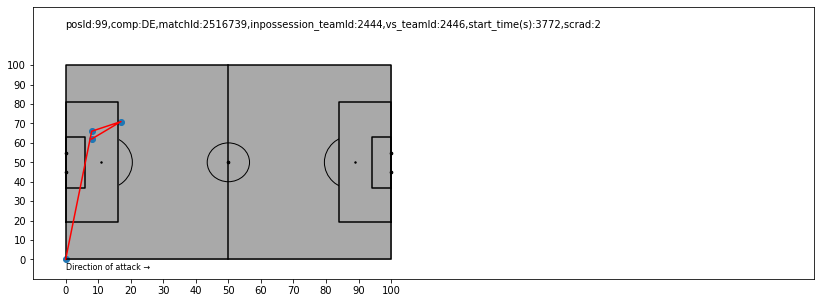

In [ ]:
for i in range(100):
  #i = 0
  temp0 = df.loc[df["posID"] == i,:]
  fdata = temp0.iloc[0,:]

  fig, ax = setup_soccerplot(include_labels=True)
  ax.scatter(temp0['x0'],temp0['y0'])
  ax.plot(temp0['x0'],temp0['y0'],color="red")
  ax.text(0,120,f"posId:{i},comp:{fdata['comp']},matchId:{fdata['matchId']},inpossession_teamId:{fdata['teamId']},vs_teamId:{fdata['team_vs']},start_time(s):{fdata['eventSec']},scrad:{fdata['scrad']}")
  
  fig.savefig(f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/2exploration/matchplots/test01_{i:04d}.png")
  plt.show()


# fdata = temp0.iloc[0,:]
# print(f"comp:{fdata['comp']},matchId:{fdata['matchId']},inpossession_teamId:{fdata['teamId']},vs_teamId:{fdata['team_vs']},start_time(s):{fdata['eventSec']},scrad:{fdata['scrad']}")



0
10000


Text(0.5, 1.0, 'Distribution of Number of Actions per Possession')

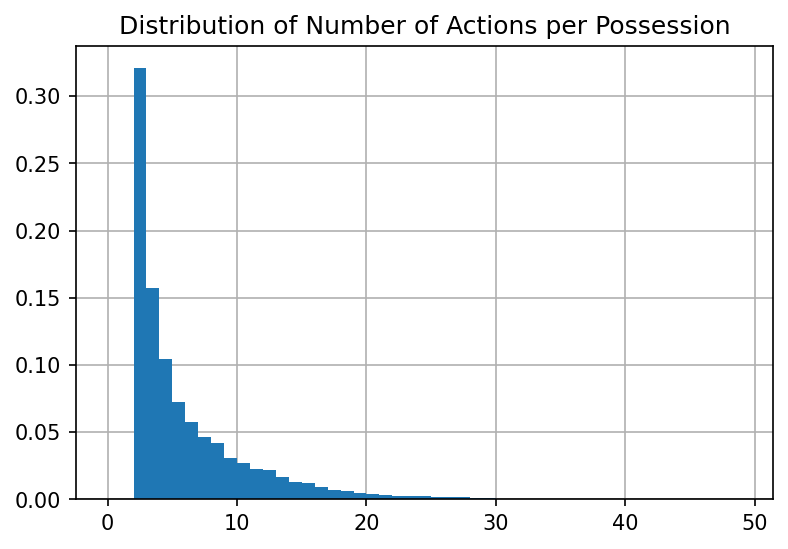

In [ ]:
possns = np.unique(df["PID"])

possns_lengths = np.zeros_like(possns)

for i in range(len(possns)):
  possn = possns[i]
  possns_lengths[i] = pd.DataFrame.sum(df["PID"] == possn)
  if i % 10000 == 0: print(i)


temp0 = possns_lengths[:20000]
fig, ax = plt.subplots()
ax.hist(temp0,bins=np.arange(0,50),density=True)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Distribution of Number of Actions per Possession")




In [ ]:
#WC final 2018 matchId = 2058017


sts = np.unique(acts['set'])

# for st in sts:
#   print(st)
i=5
st = sts[i]

temp0 = acts.loc[acts['set']==st,:]

fig, ax = setup_rugbyplot()
temp0clr = "blue" if temp0['tmpos'].iloc[0]==0 else "red"

ax.plot(temp0.loc[:,'x0'],temp0.loc[:,'y0'],color=temp0clr)
ax.text(-15,75,f"{fxd['hometeam'].to_list()[0]} vs {fxd['awayteam'].to_list()[0]}, {fxd['fxdate'].to_list()[0]}",fontsize=10)
ax.text(-15,71,f"Set: {i}/{np.shape(sts)[0]-1}  |  Home scr adv: {temp0['scrad'].to_list()[0]}",fontsize=10)

ax.text(115,70,"T\n"+"\n".join(str(e) for e in temp0['T'].to_list()),va="top",fontsize=6)
ax.text(125,70,"x0\n"+"\n".join(str(e) for e in temp0['x0'].to_list()),va="top",fontsize=6)
ax.text(130,70,"y0\n"+"\n".join(str(e) for e in temp0['y0'].to_list()),va="top",fontsize=6)
ax.text(135,70,"x1\n"+"\n".join(str(e) for e in temp0['x1'].to_list()),va="top",fontsize=6)
ax.text(140,70,"y1\n"+"\n".join(str(e) for e in temp0['y1'].to_list()),va="top",fontsize=6)
ax.text(150,70,"a0\n"+"\n".join(str(e) for e in temp0['a0_tx'].to_list()),va="top",fontsize=6)
ax.text(170,70,"a0t\n"+"\n".join(str(e) for e in temp0['a0t_tx'].to_list()),va="top",fontsize=6)
ax.text(190,70,"a0r\n"+"\n".join(str(e) for e in temp0['a0r_tx'].to_list()),va="top",fontsize=6)
for i in range(np.shape(temp0)[0]):
  ax.text(temp0['x0'].iloc[i],temp0['y0'].iloc[i],temp0['T'].iloc[i],fontsize=6)

In [ ]:
sts = np.unique(acts['set'])

for st in sts:
  print(st)

  temp0 = acts.loc[acts['set']==st,:]

  fig, ax = setup_rugbyplot()
  temp0clr = "blue" if temp0['tmpos'].iloc[0]==0 else "red"

  ax.plot(temp0.loc[:,'x0'],temp0.loc[:,'y0'],color=temp0clr)
  ax.text(-15,75,f"{fxd['hometeam'].to_list()[0]} vs {fxd['awayteam'].to_list()[0]}, {fxd['fxdate'].to_list()[0]}",fontsize=10)
  ax.text(-15,71,f"Set: {st}/{np.shape(sts)[0]-1}  |  Home scr adv: {temp0['scrad'].to_list()[0]}",fontsize=10)

  ax.text(115,70,"T\n"+"\n".join(str(e) for e in temp0['T'].to_list()),va="top",fontsize=6)
  ax.text(125,70,"x0\n"+"\n".join(str(e) for e in temp0['x0'].to_list()),va="top",fontsize=6)
  ax.text(130,70,"y0\n"+"\n".join(str(e) for e in temp0['y0'].to_list()),va="top",fontsize=6)
  ax.text(135,70,"x1\n"+"\n".join(str(e) for e in temp0['x1'].to_list()),va="top",fontsize=6)
  ax.text(140,70,"y1\n"+"\n".join(str(e) for e in temp0['y1'].to_list()),va="top",fontsize=6)
  ax.text(150,70,"a0\n"+"\n".join(str(e) for e in temp0['a0_tx'].to_list()),va="top",fontsize=6)
  ax.text(170,70,"a0t\n"+"\n".join(str(e) for e in temp0['a0t_tx'].to_list()),va="top",fontsize=6)
  ax.text(190,70,"a0r\n"+"\n".join(str(e) for e in temp0['a0r_tx'].to_list()),va="top",fontsize=6)
  for i in range(np.shape(temp0)[0]):
    ax.text(temp0['x0'].iloc[i],temp0['y0'].iloc[i],temp0['T'].iloc[i],fontsize=6)

  plt.savefig(f"/content/gdrive/MyDrive/COMP6200project/Exploration/matches03/{fxd['fxtid'].to_list()[0]:04d}_set_{st:04d}.png")

  #plt.show()